## Libraries

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import sys
import seaborn as sns
import xgboost
import time

from xgboost import XGBClassifier

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, cross_val_predict

from mlxtend.classifier import StackingClassifier

from typing import List, Dict

from bins import bins

This notebooks contains a simple workflow to create a predictive model to estimate the `prob_of_default` and a methodology to estimate an interest rate. 


In [2]:
data = pd.read_csv("credit_risk_data_v2.csv")

/var/folders/9y/1q6x1h057mbdx_d673c8wglh0000gn/T/ipykernel_36564/2644908317.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("credit_risk_data_v2.csv")


## Raw data

Here you can see our data without processing.

In [3]:
data

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,status
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,8598660,1440975,18400,18400,18400.0,60 months,14.47,432.64,C,C2,...,NaN,NaN,NaN,NaN,NaN,29900.0,NaN,NaN,NaN,0
466281,9684700,11536848,22000,22000,22000.0,60 months,19.97,582.50,D,D5,...,NaN,NaN,NaN,NaN,NaN,39400.0,NaN,NaN,NaN,1
466282,9584776,11436914,20700,20700,20700.0,60 months,16.99,514.34,D,D1,...,NaN,NaN,NaN,NaN,NaN,13100.0,NaN,NaN,NaN,0
466283,9604874,11457002,2000,2000,2000.0,36 months,7.90,62.59,A,A4,...,NaN,NaN,NaN,NaN,NaN,53100.0,NaN,NaN,NaN,0


## Preprocessing

This is a summary where we can find which columns that are empty or need to be changed.

In [3]:
summary = pd.DataFrame(data.isnull().sum())
summary = summary.rename(columns={0: "Missing_values"})
summary

,Missing_values
id,0
member_id,0
loan_amnt,0
funded_amnt,0
funded_amnt_inv,0
...,...
total_rev_hi_lim,70276
inq_fi,466285
total_cu_tl,466285
inq_last_12m,466285


We use a filter to see which ones need to be totally erased.

In [4]:
#Columnas que no contienen información en ninguna linea, se van a eliminar.
summary[summary["Missing_values"]==len(data)]

,Missing_values
annual_inc_joint,466285
dti_joint,466285
verification_status_joint,466285
open_acc_6m,466285
open_il_6m,466285
open_il_12m,466285
open_il_24m,466285
mths_since_rcnt_il,466285
total_bal_il,466285
il_util,466285


After that we see column by column and process each one of them to get everything ready for our project.

In [5]:
# Treat individual columns in the dataset
data = data.drop(summary[summary["Missing_values"]==len(data)].index, axis=1)
data = data[data['annual_inc'].notna()]
data = data[data['delinq_2yrs'].notna()]
data = data[data["inq_last_6mths"].notna()]
data["mths_since_last_delinq"].fillna(0, inplace = True)
data = data.drop(["mths_since_last_record", "url", "application_type", "issue_d", "emp_title", "desc", "id", "member_id", "title", "earliest_cr_line", "next_pymnt_d", "last_credit_pull_d", "last_pymnt_d"], axis=1)
data = data[data["open_acc"].notna()]
data = data[data["pub_rec"].notna()]
data["revol_util"].fillna(data[data["revol_util"].notna()]["revol_util"].mean(), inplace = True)
data = data[data["total_acc"].notna()]
data["collections_12_mths_ex_med"].fillna(12, inplace = True)
data = data.drop("mths_since_last_major_derog", axis=1)
data = data[data["acc_now_delinq"].notna()]
data["tot_coll_amt"].fillna(data[data["tot_coll_amt"].notna()]["tot_coll_amt"].mean(), inplace = True)
data["tot_cur_bal"].fillna(data[data["tot_cur_bal"].notna()]["tot_cur_bal"].mean(), inplace = True)
data["total_rev_hi_lim"].fillna(data[data["total_rev_hi_lim"].notna()]["total_rev_hi_lim"].mean(), inplace = True)
data = data.drop(data[data['home_ownership'] == 'ANY'].index)
data = data.drop(data[data['addr_state'] == 'ME'].index)
df = data.drop(['funded_amnt', 'funded_amnt_inv', 'emp_length',
       'installment', 
       'zip_code', 'revol_bal',
       'total_acc', 
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'policy_code', 'out_prncp',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'], axis=1)

This is the final dataframe where you can see all the columns we kept.

In [6]:
df

,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,...,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_util,initial_list_status,acc_now_delinq,status
0,5000,36 months,10.65,B,B2,RENT,24000.0,Verified,n,credit_card,...,27.65,0.0,1.0,0.0,3.0,0.0,83.7,f,0.0,0
1,2500,60 months,15.27,C,C4,RENT,30000.0,Source Verified,n,car,...,1.00,0.0,5.0,0.0,3.0,0.0,9.4,f,0.0,1
2,2400,36 months,15.96,C,C5,RENT,12252.0,Not Verified,n,small_business,...,8.72,0.0,2.0,0.0,2.0,0.0,98.5,f,0.0,0
3,10000,36 months,13.49,C,C1,RENT,49200.0,Source Verified,n,other,...,20.00,0.0,1.0,35.0,10.0,0.0,21.0,f,0.0,0
4,3000,60 months,12.69,B,B5,RENT,80000.0,Source Verified,n,other,...,17.94,0.0,0.0,38.0,15.0,0.0,53.9,f,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,18400,60 months,14.47,C,C2,MORTGAGE,110000.0,Source Verified,n,debt_consolidation,...,19.85,0.0,2.0,0.0,18.0,0.0,77.6,w,0.0,0
466281,22000,60 months,19.97,D,D5,MORTGAGE,78000.0,Verified,n,debt_consolidation,...,18.45,0.0,5.0,0.0,18.0,1.0,46.3,f,0.0,1
466282,20700,60 months,16.99,D,D1,MORTGAGE,46000.0,Verified,n,debt_consolidation,...,25.65,0.0,2.0,65.0,18.0,0.0,51.1,f,0.0,0
466283,2000,36 months,7.90,A,A4,OWN,83000.0,Verified,n,credit_card,...,5.39,3.0,1.0,13.0,21.0,0.0,21.5,w,0.0,0


Columns to keep:

1. `loan_amnt`: refers to the total amount of money being borrowed by the borrower.
2. `term`: refers to the length of the loan, typically measured in months.
3. `int_rate`: refers to the interest rate assigned to the loan.
4. `grade`: refers to the credit rating assigned to the borrower by the lender, based on factors such as credit score, credit history, and debt-to-income ratio.
5. `sub_grade`: refers to a letter and number combination that represents the borrower's creditworthiness, based on a variety of factors such as credit score, credit history, and debt-to-income ratio.
6. `pymnt_plan`: indicates whether the borrower has elected to participate in a payment plan, which allows them to make smaller payments over a longer period of time.
7. `emp_length`: refers to the length of time the borrower has been employed, typically measured in years.
8. `home_ownership`: refers to whether the borrower owns or rents their primary residence.
9. `annual_inc`: refers to the borrower's total annual income.
10. `verification_status`: refers to the level of verification the lender has obtained for the borrower's income and other financial information.
11. `purpose`: refers to the reason for the loan, such as debt consolidation, home improvement, or medical expenses.
12. `addr_state`: refers to the state in which the borrower's address is located.
13. `mths_since_last_delinq`: refers to the number of months that have passed since the borrower's last delinquency, which is when they failed to make a required payment on time.
14. `dti`: debt to income ratio
15. `delinq_2yrs`: number of times the borrower had been 30+ days past due on a payment in the past 2 years
16. `inq_last_6mths`: The number of inquiries by creditors during the past 6 months.
17. `open_acc`: refers to the number of open credit accounts that the borrower has.
18. `pub_rec`: refers to the number of negative public records (such as bankruptcies or foreclosures) that the borrower has on their credit history.
19. `revol_util`: refers to the amount of credit the borrower is currently using as a percentage of their total available credit.
20. `initial_list_status`: refers to whether the loan was initially listed as "funded" or "not funded" when it was first issued.
21. `acc_now_delinq`: refers to the number of accounts on which the borrower is currently delinquent (i.e. behind on payments).
22. `status`: refers to the current status of the loan (such as "current," "late," or "default").


## EDA

As all of us know, before we start with our processing, it is necessary to analize what kind of info we have, that is why we need EDA, that gives us a fast summary and an idea of what we will be exploring.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 466251 entries, 0 to 466284
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   loan_amnt               466251 non-null  int64  
 1   term                    466251 non-null  object 
 2   int_rate                466251 non-null  float64
 3   grade                   466251 non-null  object 
 4   sub_grade               466251 non-null  object 
 5   home_ownership          466251 non-null  object 
 6   annual_inc              466251 non-null  float64
 7   verification_status     466251 non-null  object 
 8   pymnt_plan              466251 non-null  object 
 9   purpose                 466251 non-null  object 
 10  addr_state              466251 non-null  object 
 11  dti                     466251 non-null  float64
 12  delinq_2yrs             466251 non-null  float64
 13  inq_last_6mths          466251 non-null  float64
 14  mths_since_last_delinq  4

The past summary is to see what kind of data we have in each column, now this dataframe more related to numerical info.

In [8]:
df.describe()

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_util,acc_now_delinq,status
count,466251.000000,466251.000000,4.662510e+05,466251.000000,466251.000000,466251.000000,466251.000000,466251.000000,466251.000000,466251.000000,466251.000000,466251.000000
mean,14317.984358,13.829536,7.327791e+04,17.219403,0.284681,0.804734,15.794555,11.187133,0.160566,56.177189,0.004002,0.109308
std,8286.291170,4.357574,5.496312e+04,7.850860,0.797369,1.091594,22.557866,4.987512,0.510865,23.724575,0.068637,0.312026
min,500.000000,5.420000,1.896000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8000.000000,10.990000,4.500000e+04,11.360000,0.000000,0.000000,0.000000,8.000000,0.000000,39.200000,0.000000,0.000000
50%,12000.000000,13.660000,6.300000e+04,16.870000,0.000000,0.000000,0.000000,10.000000,0.000000,57.500000,0.000000,0.000000
75%,20000.000000,16.490000,8.895650e+04,22.780000,0.000000,1.000000,28.000000,14.000000,0.000000,74.700000,0.000000,0.000000
max,35000.000000,26.060000,7.500000e+06,39.990000,29.000000,33.000000,188.000000,84.000000,63.000000,892.300000,5.000000,1.000000


In [9]:
def EDA(data,col):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    sns.histplot(x=col, data=df)
    plt.title("Distribution")

    plt.subplot(1,2,2)
    ax = df.boxplot(column=col, patch_artist=True, color='navy',boxprops=dict(facecolor='lightsteelblue', edgecolor='navy', linewidth=1), flierprops=dict(markerfacecolor='red', markeredgecolor='red'))
    plt.show()
    
def calculate_correlation_matrix(data):
    # Seleccionar solo las columnas numéricas
    numeric_data = data.select_dtypes(include=[np.number])
    
    # Calcular la matriz de correlación
    correlation_matrix = numeric_data.corr()

    return correlation_matrix

Correlation is a parameter that helps us to see if a variable is similar to another and take action on our data columns to have less information that is why we always need to do this, depending on each case is what we do.

In [10]:
correlation_matrix_df = calculate_correlation_matrix(df)
correlation_matrix_df

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_util,acc_now_delinq,status
loan_amnt,1.000000,0.167111,0.370915,0.057233,0.006839,-0.020322,-0.028732,0.204176,-0.081140,0.117702,0.006283,0.011817
int_rate,0.167111,1.000000,-0.046075,0.159587,0.079188,0.205648,0.069288,0.012300,0.066693,0.323249,0.030338,0.172366
annual_inc,0.370915,-0.046075,1.000000,-0.188567,0.058893,0.056683,0.018232,0.157776,-0.015441,0.037550,0.017133,-0.049851
dti,0.057233,0.159587,-0.188567,1.000000,-0.003697,-0.012530,-0.011347,0.303909,-0.046195,0.200325,0.009490,0.048100
delinq_2yrs,0.006839,0.079188,0.058893,-0.003697,1.000000,0.017989,-0.060226,0.059130,-0.010812,-0.013179,0.126532,0.001226
inq_last_6mths,-0.020322,0.205648,0.056683,-0.012530,0.017989,1.000000,0.033095,0.092803,0.038331,-0.094654,-0.006917,0.073106
mths_since_last_delinq,-0.028732,0.069288,0.018232,-0.011347,-0.060226,0.033095,1.000000,0.022652,0.067436,0.003392,-0.038394,-0.004800
open_acc,0.204176,0.012300,0.157776,0.303909,0.059130,0.092803,0.022652,1.000000,-0.030482,-0.124188,0.018193,-0.006179
pub_rec,-0.081140,0.066693,-0.015441,-0.046195,-0.010812,0.038331,0.067436,-0.030482,1.000000,-0.062489,0.002348,-0.009112
revol_util,0.117702,0.323249,0.037550,0.200325,-0.013179,-0.094654,0.003392,-0.124188,-0.062489,1.000000,-0.022748,0.050178


Here in addition to the past section, we can see how the correlation is in our dataframe.

<Axes: >

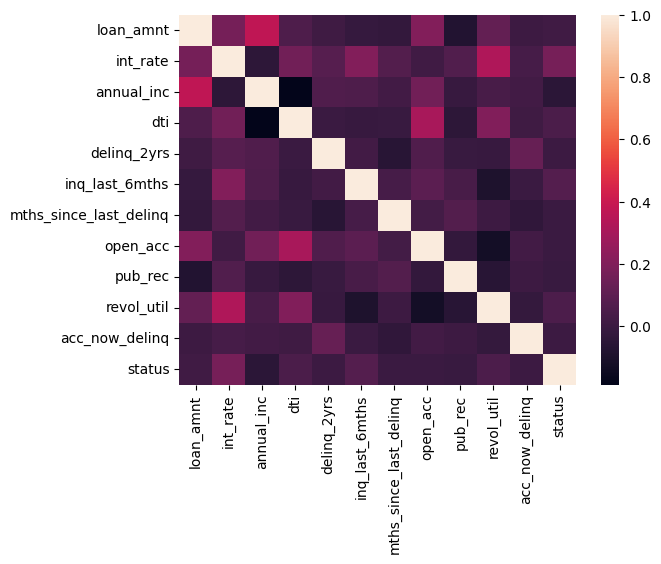

In [11]:
sns.heatmap(correlation_matrix_df)

### Predictor Loan Amout

We consider "loan_amount" to be a good predictor for our model, since when determining a loan, the authorized amount is the result of determining factors whether the client is a good payer or not.

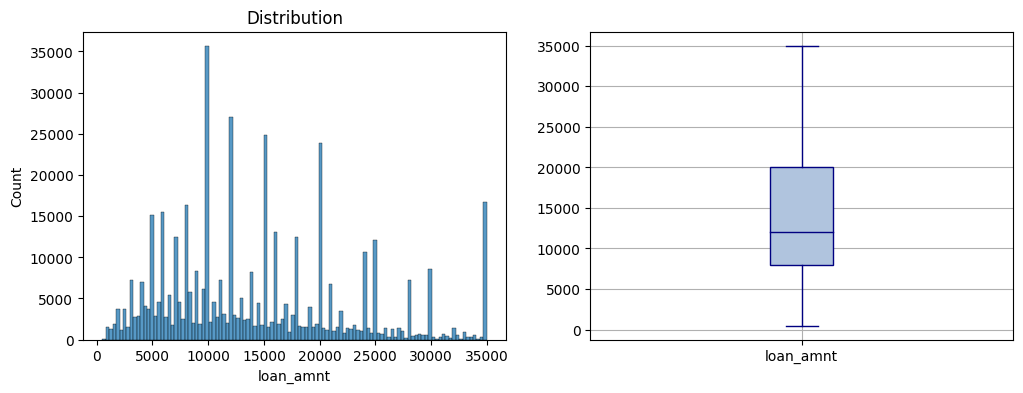

In [12]:
EDA(df,"loan_amnt")

### Predictor interest rate

We opted for the "int_rate" predictor as we believe that higher interest rates assigned to clients correspond to a greater risk of default. As experienced programmers, we consider this to be a reliable way of determining a client's credit score.

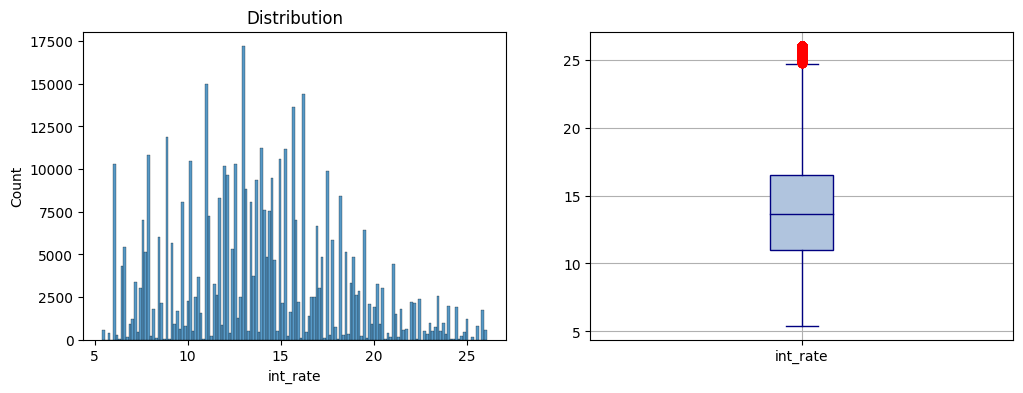

In [13]:
EDA(df,"int_rate")

### Predictor annual income

We selected "annual_income" as a predictor since it determines the likelihood of a client's ability to pay off their debts. However, the data column contained some outliers that impacted the visualization of the data. Therefore, as experienced programmers, we removed the data located in the tails of the distribution to avoid such extraordinary cases.

### Handle Outliers

In [14]:
Q1 = df['annual_inc'].quantile(0.25)
Q3 = df['annual_inc'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtra los datos para eliminar los outliers
filtered_data = df[(df['annual_inc'] >= lower_bound) & (df['annual_inc'] <= upper_bound)]

# Sobrescribe el DataFrame original con los datos filtrados
df = filtered_data

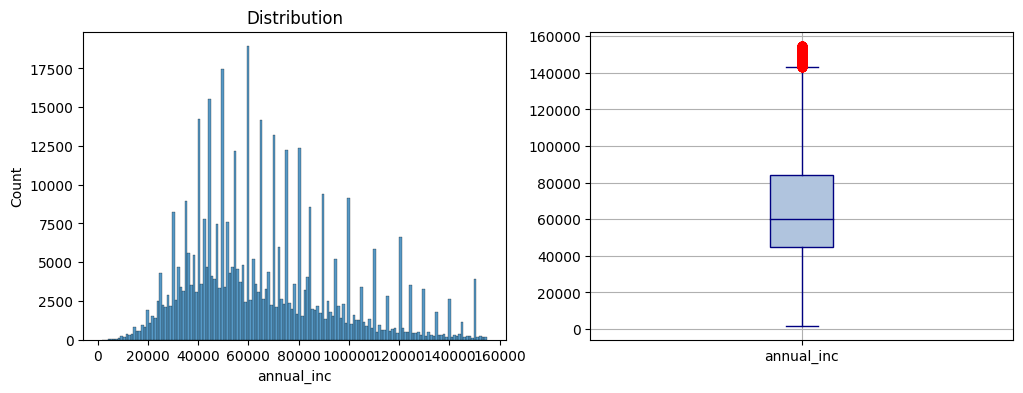

In [15]:
EDA(df,"annual_inc")

## Predictor debt to income ratio

We chose this variable because it will help us to identify how much debt a company has compared to its assets. It would help us analyze risk analysis, comparability, the investment analysis and more. In other words it is a useful variable for analyzing a company's financial health, risk profile, and investment potential.

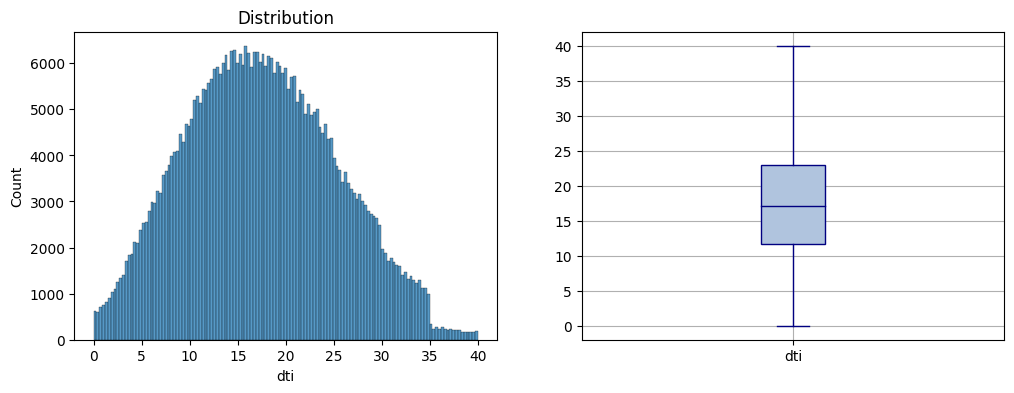

In [16]:
EDA(df,"dti")

 ## Predictor revol util

We think this variable is important because this shows how the borrower distributes his or her credit a long the credit period.

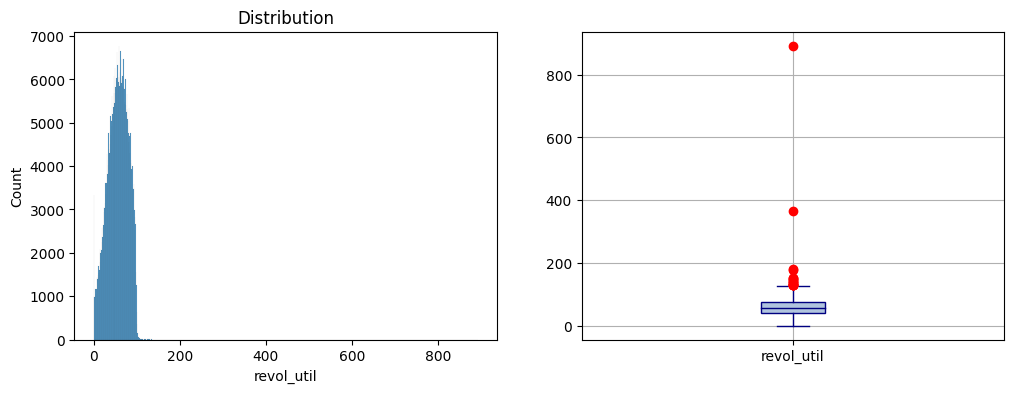

In [17]:
EDA(df,"revol_util")

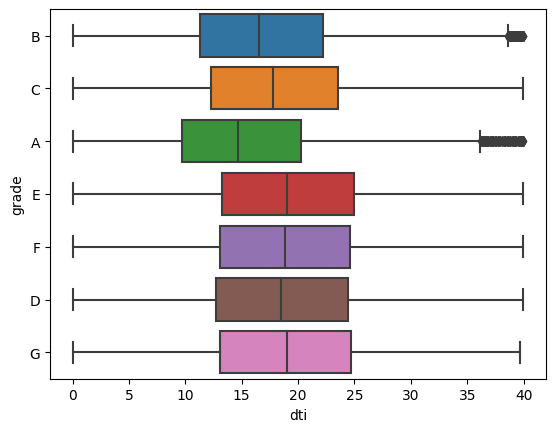

In [18]:
sns.boxplot( x="dti", y='grade', data=df, )
plt.show()

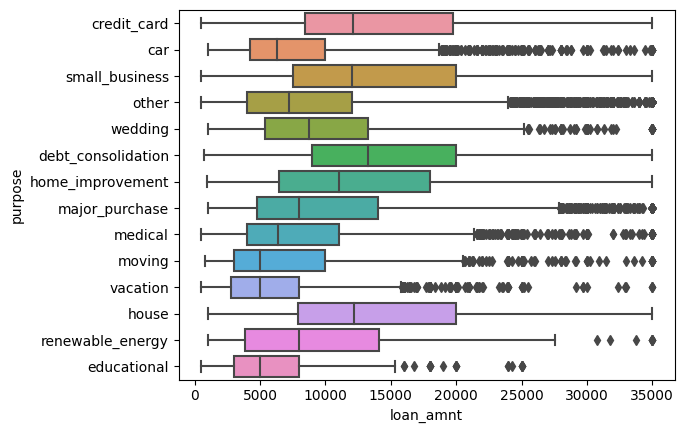

In [19]:
sns.boxplot( x="loan_amnt", y='purpose', data=df, )
plt.show()

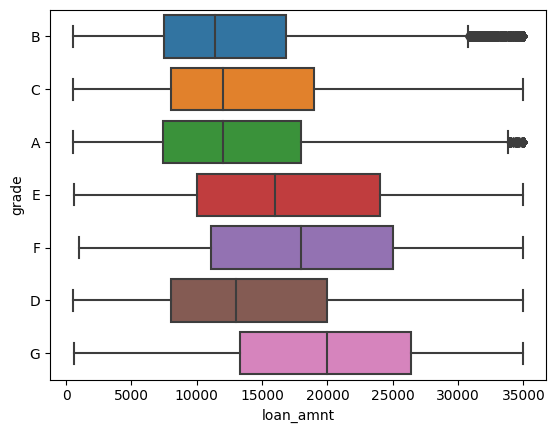

In [20]:
sns.boxplot( x="loan_amnt", y= "grade", data=df, )
plt.show()

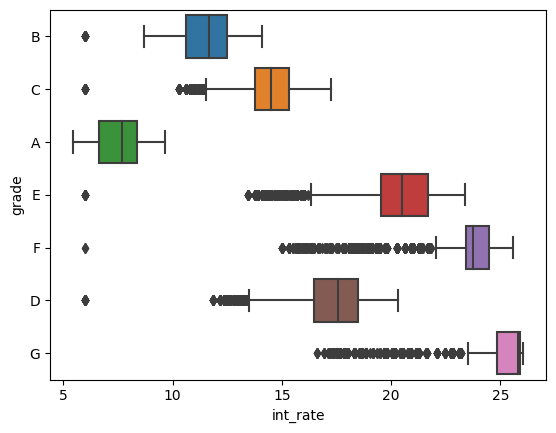

In [21]:
sns.boxplot( x="int_rate", y= "grade", data=df, )
plt.show()

## BINNING
We take the original data and transform the following continuous variables into categorical values:
- Loan amount
- Interest rate
- Annual income
- Months since las delinq
- DTI
- Delinq 2 years
- Inquirment last 6 months
- Open accounts
- Public records
- Accounts now delinqued

In [22]:
class ColumnSelectorTransformer:
    def __init__(self, columns: List[str]):
        self.columns = columns
    
    def transform(self, X: pd.DataFrame, y: pd.DataFrame = None) -> pd.DataFrame:
        return X.loc[:, self.columns]
    
    def fit(self, *args, **kwargs): 
        return self
    
    def __str__(self) -> str:
        return f"ColumnSelectorTransformer({self.columns})"
    
    def __repr__(self) -> str:
        return f"ColumnSelectorTransformer({self.columns})"
    

class BinningTransformer:
    def __init__(self, bins: Dict):
        self.bins = bins
        
    def __find_bin(self, value: float, mappings: List):
        for mapping in mappings:
            if value <= mapping["max"]:
                return mapping["label"]
        return "Error"
        
    def transform(self, X: pd.DataFrame, y: pd.DataFrame = None) -> pd.DataFrame:
        X = X.copy()
        for key in self.bins.keys():
            X.loc[:, key] = X.loc[:, key].transform(lambda x: self.__find_bin(x, self.bins[key]))
        return X

    def fit(self, *args, **kwargs):
        return self
    
    def __str__(self) -> str:
        return "BinningTransformer()"
    
    def __repr__(self) -> str:
        return "BinningTransformer()"

    
class WOETransformer:
    def __init__(self, columns: List[str], target_mappings: Dict = {0: "good", 1: "bad"}):
        self.target_mappings = target_mappings
        self.columns = columns
        self.woe_mappings = None
    
    def __get_absolute_odds(self, df: pd.DataFrame, col: str):
        key_first, key_second = list(self.target_mappings.keys())
        return (
            df.query(f"status=={key_first}")
            .groupby(col).size().reset_index()
            .rename(columns={0: self.target_mappings[key_first]})
            .set_index(col)
        ).join(
            df.query(f"status=={key_second}")
            .groupby(col).size().reset_index()
            .rename(columns={0: self.target_mappings[key_second]})
            .set_index(col)
        ).reset_index()[[col, "good", "bad"]]

    @staticmethod
    def __calculate_relative_odds(row: pd.Series, total_good: int, total_bad: int) -> pd.Series:
        return pd.Series(
            {
                **row.to_dict(),
                "good": row["good"] / total_good,
                "bad": row["bad"] / total_bad
            }
        )

    def __get_odds(self, df: pd.DataFrame, col: str,
                   absolute_values: bool = False) -> pd.DataFrame:
        key_first, key_second = list(self.target_mappings.keys())
        odds_absolute = self.__get_absolute_odds(df, col)

        if absolute_values:
            return odds_absolute

        # Relative Odds
        total_good = odds_absolute["good"].sum()
        total_bad = odds_absolute["bad"].sum()
        return odds_absolute.apply(
            lambda row: WOETransformer.__calculate_relative_odds(row, total_good, total_bad),
            axis=1
        )

    @staticmethod
    def __calculate_woe(row: pd.Series) -> pd.Series:
        return pd.Series(
            {
                **row.to_dict(),
                "woe": np.log(row["good"] / row["bad"]),
                "info_val": (row["good"] - row["bad"]) * np.log(row["good"] / row["bad"])
            }
        )

    def __set_woe_mappings(self, X: pd.DataFrame, y: pd.Series,
                           absolute_values: bool = False) -> None:
        df = X.copy()
        df["status"] = y
        
        self.woe_mappings = {
            col: self.__get_odds(df, col, absolute_values)\
                .apply(lambda row: WOETransformer.__calculate_woe(row), axis=1)\
                .sort_values(by="woe", axis=0, ascending=True)
            for col in self.columns
        }
        
    def fit(self, X: pd.DataFrame, y: pd.DataFrame, *args, **kwargs):
        self.__set_woe_mappings(X, y, *args, **kwargs)
        return self
    
    def transform(self, X: pd.DataFrame, y: pd.DataFrame = None) -> pd.DataFrame:
        if self.woe_mappings is None:
            raise NotFittedError(f"This {self} instance is not fitted yet. Call 'fit' with appropriate arguments before using this transformer.")
        df = X.copy()
        out = pd.DataFrame([])
        for col in df.columns:
            mapping = self.woe_mappings[col].set_index(col)
            categories = list(mapping.index)
            out[col] = df.loc[:, col].apply(lambda cat: mapping.loc[cat, "woe"])
        return out
    
    def __str__(self) -> str:
        return f"WOETransformer(columns={self.columns}, target_mappings={self.target_mappings})"
    
    def __repr__(self) -> str:
        return f"WOETransformer(columns={self.columns}, target_mappings={self.target_mappings})"

In [23]:
x_train = df.drop("status", axis=1)
y_train = df["status"]

cols_to_keep = ['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util',
       'initial_list_status', 'acc_now_delinq']

In [24]:
column_t = ColumnSelectorTransformer(columns=cols_to_keep)
column_t

ColumnSelectorTransformer(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util', 'initial_list_status', 'acc_now_delinq'])

In [25]:
binning_t = BinningTransformer(bins=bins)
binning_t

BinningTransformer()

In [26]:
woe_t = WOETransformer(columns=cols_to_keep)

In [27]:
woe_t

WOETransformer(columns=['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util', 'initial_list_status', 'acc_now_delinq'], target_mappings={0: 'good', 1: 'bad'})

In [28]:
x_train_c = column_t.transform(x_train)
x_train_c

,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_util,initial_list_status,acc_now_delinq
0,5000,36 months,10.65,B,B2,RENT,24000.0,Verified,n,credit_card,AZ,27.65,0.0,1.0,0.0,3.0,0.0,83.7,f,0.0
1,2500,60 months,15.27,C,C4,RENT,30000.0,Source Verified,n,car,GA,1.00,0.0,5.0,0.0,3.0,0.0,9.4,f,0.0
2,2400,36 months,15.96,C,C5,RENT,12252.0,Not Verified,n,small_business,IL,8.72,0.0,2.0,0.0,2.0,0.0,98.5,f,0.0
3,10000,36 months,13.49,C,C1,RENT,49200.0,Source Verified,n,other,CA,20.00,0.0,1.0,35.0,10.0,0.0,21.0,f,0.0
4,3000,60 months,12.69,B,B5,RENT,80000.0,Source Verified,n,other,OR,17.94,0.0,0.0,38.0,15.0,0.0,53.9,f,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,18400,60 months,14.47,C,C2,MORTGAGE,110000.0,Source Verified,n,debt_consolidation,TX,19.85,0.0,2.0,0.0,18.0,0.0,77.6,w,0.0
466281,22000,60 months,19.97,D,D5,MORTGAGE,78000.0,Verified,n,debt_consolidation,TN,18.45,0.0,5.0,0.0,18.0,1.0,46.3,f,0.0
466282,20700,60 months,16.99,D,D1,MORTGAGE,46000.0,Verified,n,debt_consolidation,OH,25.65,0.0,2.0,65.0,18.0,0.0,51.1,f,0.0
466283,2000,36 months,7.90,A,A4,OWN,83000.0,Verified,n,credit_card,CA,5.39,3.0,1.0,13.0,21.0,0.0,21.5,w,0.0


In [29]:
x_train_b = binning_t.transform(x_train_c)
x_train_b

,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_util,initial_list_status,acc_now_delinq
0,"(-inf, 15000)",36 months,"(9, 21)",B,B2,RENT,"(-inf, 70000)",Verified,n,credit_card,AZ,"(15, inf)","(-inf, 10)","(-inf, 15)","(-inf, 12)","(-inf, 30)","(-inf, 5)","(75, inf)",f,"(-inf, 2)"
1,"(-inf, 15000)",60 months,"(9, 21)",C,C4,RENT,"(-inf, 70000)",Source Verified,n,car,GA,"(-inf, 15)","(-inf, 10)","(-inf, 15)","(-inf, 12)","(-inf, 30)","(-inf, 5)","(-inf, 75)",f,"(-inf, 2)"
2,"(-inf, 15000)",36 months,"(9, 21)",C,C5,RENT,"(-inf, 70000)",Not Verified,n,small_business,IL,"(-inf, 15)","(-inf, 10)","(-inf, 15)","(-inf, 12)","(-inf, 30)","(-inf, 5)","(75, inf)",f,"(-inf, 2)"
3,"(-inf, 15000)",36 months,"(9, 21)",C,C1,RENT,"(-inf, 70000)",Source Verified,n,other,CA,"(15, inf)","(-inf, 10)","(-inf, 15)","(12, inf)","(-inf, 30)","(-inf, 5)","(-inf, 75)",f,"(-inf, 2)"
4,"(-inf, 15000)",60 months,"(9, 21)",B,B5,RENT,"(70000, inf)",Source Verified,n,other,OR,"(15, inf)","(-inf, 10)","(-inf, 15)","(12, inf)","(-inf, 30)","(-inf, 5)","(-inf, 75)",f,"(-inf, 2)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,"(15000, inf)",60 months,"(9, 21)",C,C2,MORTGAGE,"(70000, inf)",Source Verified,n,debt_consolidation,TX,"(15, inf)","(-inf, 10)","(-inf, 15)","(-inf, 12)","(-inf, 30)","(-inf, 5)","(75, inf)",w,"(-inf, 2)"
466281,"(15000, inf)",60 months,"(9, 21)",D,D5,MORTGAGE,"(70000, inf)",Verified,n,debt_consolidation,TN,"(15, inf)","(-inf, 10)","(-inf, 15)","(-inf, 12)","(-inf, 30)","(-inf, 5)","(-inf, 75)",f,"(-inf, 2)"
466282,"(15000, inf)",60 months,"(9, 21)",D,D1,MORTGAGE,"(-inf, 70000)",Verified,n,debt_consolidation,OH,"(15, inf)","(-inf, 10)","(-inf, 15)","(12, inf)","(-inf, 30)","(-inf, 5)","(-inf, 75)",f,"(-inf, 2)"
466283,"(-inf, 15000)",36 months,"(-inf, 9)",A,A4,OWN,"(70000, inf)",Verified,n,credit_card,CA,"(-inf, 15)","(-inf, 10)","(-inf, 15)","(12, inf)","(-inf, 30)","(-inf, 5)","(-inf, 75)",w,"(-inf, 2)"


## WOE

As we know WOE is the weight of evidence adn this helps us to know which variables are better to use so here you will see a deep analysis of this: 

In [30]:
woe_t.fit(x_train_b, y_train)

WOETransformer(columns=['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util', 'initial_list_status', 'acc_now_delinq'], target_mappings={0: 'good', 1: 'bad'})

In [31]:
woe_t.transform(x_train_b).head()

,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_util,initial_list_status,acc_now_delinq
0,0.047177,0.132364,-0.051422,0.366476,0.520332,-0.152022,-0.135120,-0.185228,0.000071,0.260683,-0.014373,-0.102654,0.00019,0.000093,-0.016763,-0.000245,-0.000191,-0.207500,-0.106759,0.00001
1,0.047177,-0.296996,-0.051422,-0.053201,-0.111528,-0.152022,-0.135120,0.052569,0.000071,0.236592,0.060889,0.170980,0.00019,0.000093,-0.016763,-0.000245,-0.000191,0.074156,-0.106759,0.00001
2,0.047177,0.132364,-0.051422,-0.053201,-0.191233,-0.152022,-0.135120,0.178389,0.000071,-0.812495,0.160581,0.170980,0.00019,0.000093,-0.016763,-0.000245,-0.000191,-0.207500,-0.106759,0.00001
3,0.047177,0.132364,-0.051422,-0.053201,0.057919,-0.152022,-0.135120,0.052569,0.000071,-0.265019,-0.046885,-0.102654,0.00019,0.000093,0.028638,-0.000245,-0.000191,0.074156,-0.106759,0.00001
4,0.047177,-0.296996,-0.051422,0.366476,0.145470,-0.152022,0.261289,0.052569,0.000071,-0.265019,0.101733,-0.102654,0.00019,0.000093,0.028638,-0.000245,-0.000191,0.074156,-0.106759,0.00001


In [32]:
woe_t.woe_mappings["loan_amnt"]

,loan_amnt,good,bad,woe,info_val
1,"(15000, inf)",0.357985,0.38757,-0.079406,0.002349
0,"(-inf, 15000)",0.642015,0.61243,0.047177,0.001396


In [33]:
woe_t.woe_mappings["term"]

,term,good,bad,woe,info_val
1,60 months,0.263901,0.355161,-0.296996,0.027104
0,36 months,0.736099,0.644839,0.132364,0.012079


In [34]:
woe_t.woe_mappings["int_rate"]

,int_rate,good,bad,woe,info_val
1,"(21, inf)",0.051138,0.125232,-0.895646,0.066362
2,"(9, 21)",0.777083,0.818088,-0.051422,0.002109
0,"(-inf, 9)",0.171779,0.056680,1.108794,0.127621


In [35]:
woe_t.woe_mappings["grade"]

,grade,good,bad,woe,info_val
6,G,0.005587,0.017628,-1.149076,0.013836
5,F,0.024033,0.062051,-0.948526,0.036061
4,E,0.069143,0.135692,-0.674210,0.044868
3,D,0.157581,0.233039,-0.391262,0.029524
2,C,0.268677,0.283358,-0.053201,0.000781
1,B,0.305080,0.211473,0.366476,0.034305
0,A,0.169899,0.056760,1.096366,0.124041


In [36]:
woe_t.woe_mappings["sub_grade"]

,sub_grade,good,bad,woe,info_val
30,G1,0.001847,0.006381,-1.239647,0.005620
29,F5,0.002520,0.008582,-1.225384,0.007428
32,G3,0.000960,0.003170,-1.194497,0.002640
34,G5,0.000640,0.002039,-1.158837,0.001622
31,G2,0.001426,0.004139,-1.065466,0.002891
28,F4,0.003709,0.010217,-1.013210,0.006594
27,F3,0.004879,0.013125,-0.989644,0.008161
33,G4,0.000713,0.001898,-0.978898,0.001160
26,F2,0.005526,0.013589,-0.899770,0.007255
24,E5,0.009518,0.021747,-0.826300,0.010105


In [37]:
woe_t.woe_mappings["home_ownership"]

,home_ownership,good,bad,woe,info_val
2,OTHER,0.000348,0.000747,-0.764715,0.000305
1,NONE,0.000096,0.000162,-0.522906,0.000034
4,RENT,0.405410,0.471973,-0.152022,0.010119
3,OWN,0.090180,0.088826,0.015129,0.000020
0,MORTGAGE,0.503966,0.438293,0.139623,0.009170


In [38]:
woe_t.woe_mappings["annual_inc"]

,annual_inc,good,bad,woe,info_val
0,"(-inf, 70000)",0.613807,0.702609,-0.135120,0.011999
1,"(70000, inf)",0.386193,0.297391,0.261289,0.023203


In [39]:
woe_t.woe_mappings["verification_status"]

,verification_status,good,bad,woe,info_val
2,Verified,0.347406,0.418100,-0.185228,0.013095
1,Source Verified,0.320296,0.303893,0.052569,0.000862
0,Not Verified,0.332298,0.278007,0.178389,0.009685


In [40]:
woe_t.woe_mappings["pymnt_plan"]

,pymnt_plan,good,bad,woe,info_val
1,y,0.00001,0.000081,-2.081051,1.471075e-04
0,n,0.99999,0.999919,0.000071,4.997167e-09


In [41]:
woe_t.woe_mappings["purpose"]

,purpose,good,bad,woe,info_val
11,small_business,0.012544,0.028269,-0.812495,0.012776
3,educational,0.000816,0.001716,-0.742958,0.000669
10,renewable_energy,0.000706,0.001050,-0.397505,0.000137
8,moving,0.006098,0.009066,-0.396551,0.001177
5,house,0.004574,0.006199,-0.304058,0.000494
9,other,0.049076,0.063969,-0.265019,0.003947
7,medical,0.009525,0.012035,-0.233812,0.000587
13,wedding,0.005015,0.005593,-0.109178,0.000063
12,vacation,0.005342,0.005836,-0.088306,0.000044
2,debt_consolidation,0.588476,0.612309,-0.039701,0.000946


In [42]:
woe_t.woe_mappings["addr_state"]

,addr_state,good,bad,woe,info_val
27,NE,0.000013,0.000162,-2.551054,3.799489e-04
12,IA,0.000028,0.000061,-0.781768,2.568655e-05
31,NV,0.013759,0.017709,-0.252354,9.966816e-04
9,FL,0.066986,0.077881,-0.150706,1.642027e-03
11,HI,0.005373,0.006219,-0.146335,1.238911e-04
1,AL,0.012572,0.014377,-0.134138,2.420829e-04
32,NY,0.084623,0.091915,-0.082657,6.027248e-04
26,NC,0.027155,0.029117,-0.069760,1.368688e-04
20,MD,0.023171,0.024816,-0.068592,1.128413e-04
29,NJ,0.037278,0.039880,-0.067465,1.755252e-04


In [43]:
woe_t.woe_mappings["dti"]

,dti,good,bad,woe,info_val
1,"(15, inf)",0.59246,0.65651,-0.102654,0.006575
0,"(-inf, 15)",0.40754,0.34349,0.170980,0.010951


In [44]:
woe_t.woe_mappings["delinq_2yrs"]

,delinq_2yrs,good,bad,woe,info_val
1,"(10, inf)",0.000275,0.000464,-0.525197,9.965321e-05
0,"(-inf, 10)",0.999725,0.999536,0.000190,3.601628e-08


In [45]:
woe_t.woe_mappings["inq_last_6mths"]

,inq_last_6mths,good,bad,woe,info_val
1,"(15, inf)",0.000028,0.000121,-1.474915,1.378067e-04
0,"(-inf, 15)",0.999972,0.999879,0.000093,8.730506e-09


In [46]:
woe_t.woe_mappings["mths_since_last_delinq"]

,mths_since_last_delinq,good,bad,woe,info_val
0,"(-inf, 12)",0.625482,0.636055,-0.016763,0.000177
1,"(12, inf)",0.374518,0.363945,0.028638,0.000303


In [47]:
woe_t.woe_mappings["open_acc"]

,open_acc,good,bad,woe,info_val
0,"(-inf, 30)",0.996364,0.996608,-0.000245,5.975732e-08
1,"(30, inf)",0.003636,0.003392,0.069465,1.695107e-05


In [48]:
woe_t.woe_mappings["pub_rec"]

,pub_rec,good,bad,woe,info_val
0,"(-inf, 5)",0.999466,0.999657,-0.000191,3.648398e-08
1,"(5, inf)",0.000534,0.000343,0.442322,8.446848e-05


In [49]:
woe_t.woe_mappings["revol_util"]

,revol_util,good,bad,woe,info_val
1,"(75, inf)",0.23661,0.291172,-0.207500,0.011322
0,"(-inf, 75)",0.76339,0.708828,0.074156,0.004046


In [50]:
woe_t.woe_mappings["initial_list_status"]

,initial_list_status,good,bad,woe,info_val
0,f,0.642552,0.714946,-0.106759,0.007729
1,w,0.357448,0.285054,0.226312,0.016384


In [51]:
woe_t.woe_mappings["acc_now_delinq"]

,acc_now_delinq,good,bad,woe,info_val
1,"(2, inf)",0.00003,0.00004,-0.289291,2.934804e-06
0,"(-inf, 2)",0.99997,0.99996,0.000010,1.029208e-10


In [52]:
def plot_woe_bars(woe_t, columns):
    for col in columns:
        woe_df = woe_t.woe_mappings[col]
        iv = round(woe_df["info_val"].sum(), 4)
        fig, ax = plt.subplots(figsize=(12, 8))
        ax = woe_df.plot.bar(x=col, y=["good", "bad"], stacked=True, ax=ax)
        ax2 = ax.twinx()
        ax2.plot(woe_df[col], woe_df["woe"], c="r")
        ax2.set_ylabel("WOE")
        ax.set_ylabel("Relative Odds")
        ax.set_title(f"{col} (IV={iv})")  # Añadir el valor de IV al título
        plt.text(0.5, 1.1, f"IV = {iv}", ha='center', va='bottom', transform=ax.transAxes, fontsize=12) # Añadir el valor de IV como texto en la figura
        plt.show()

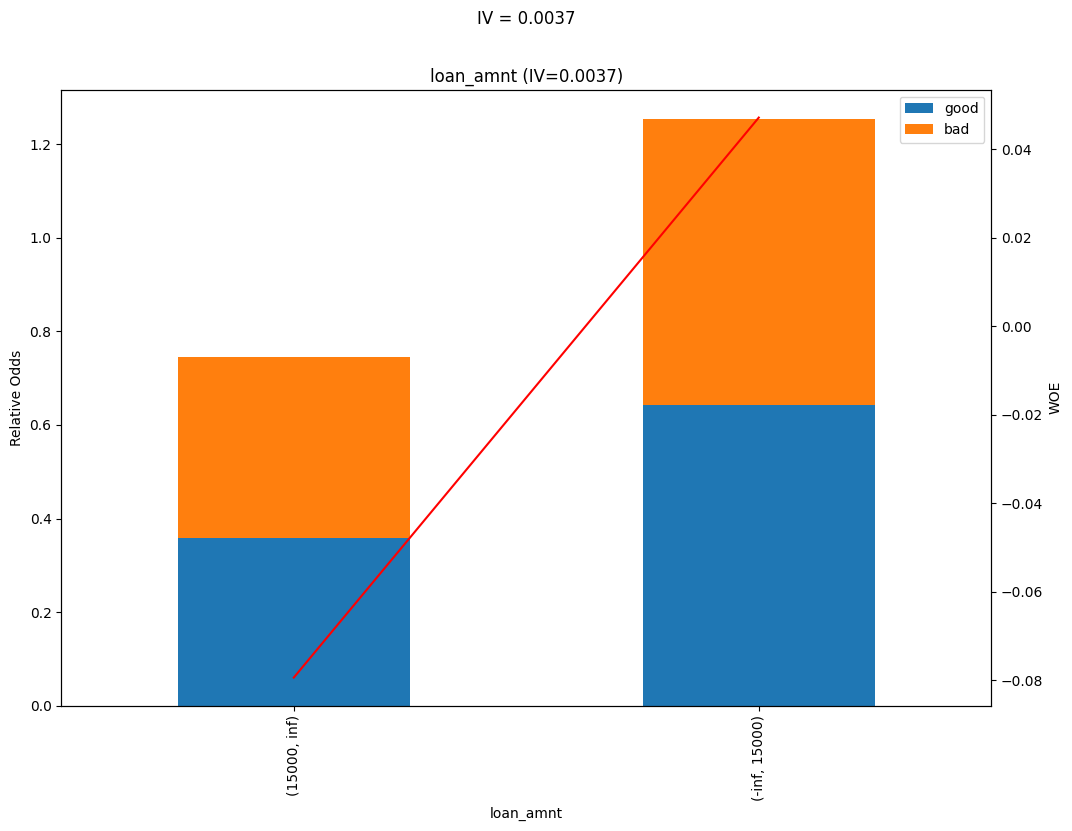

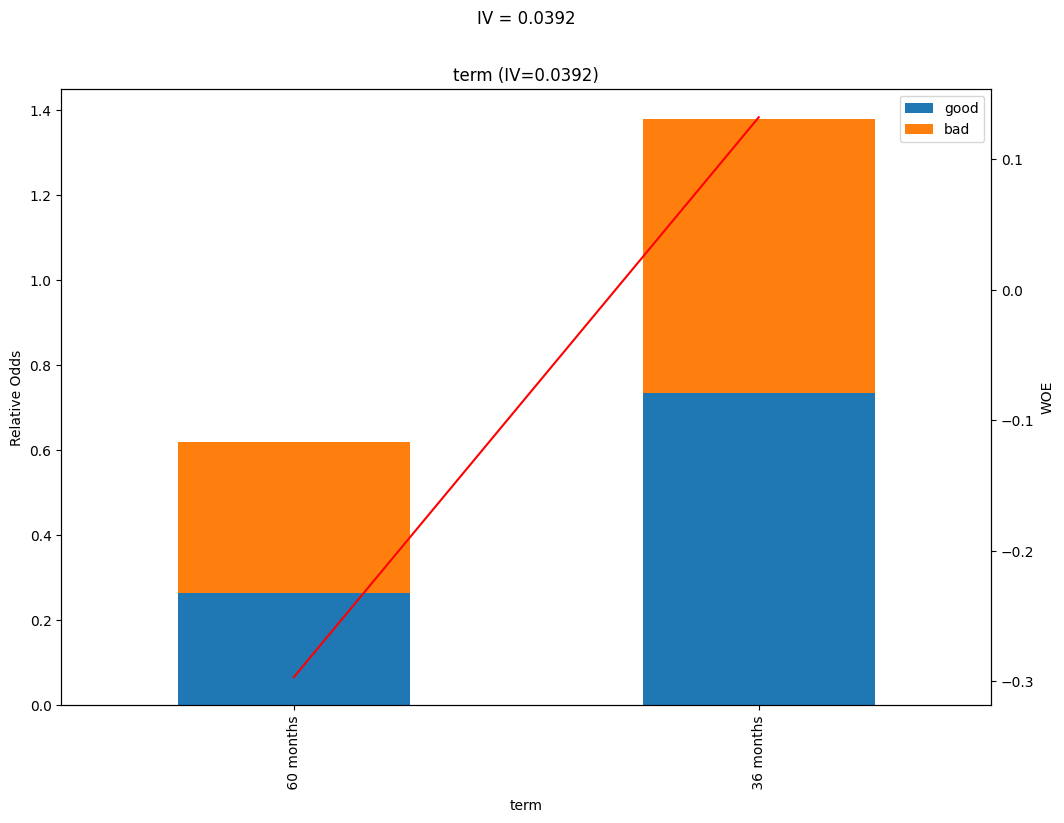

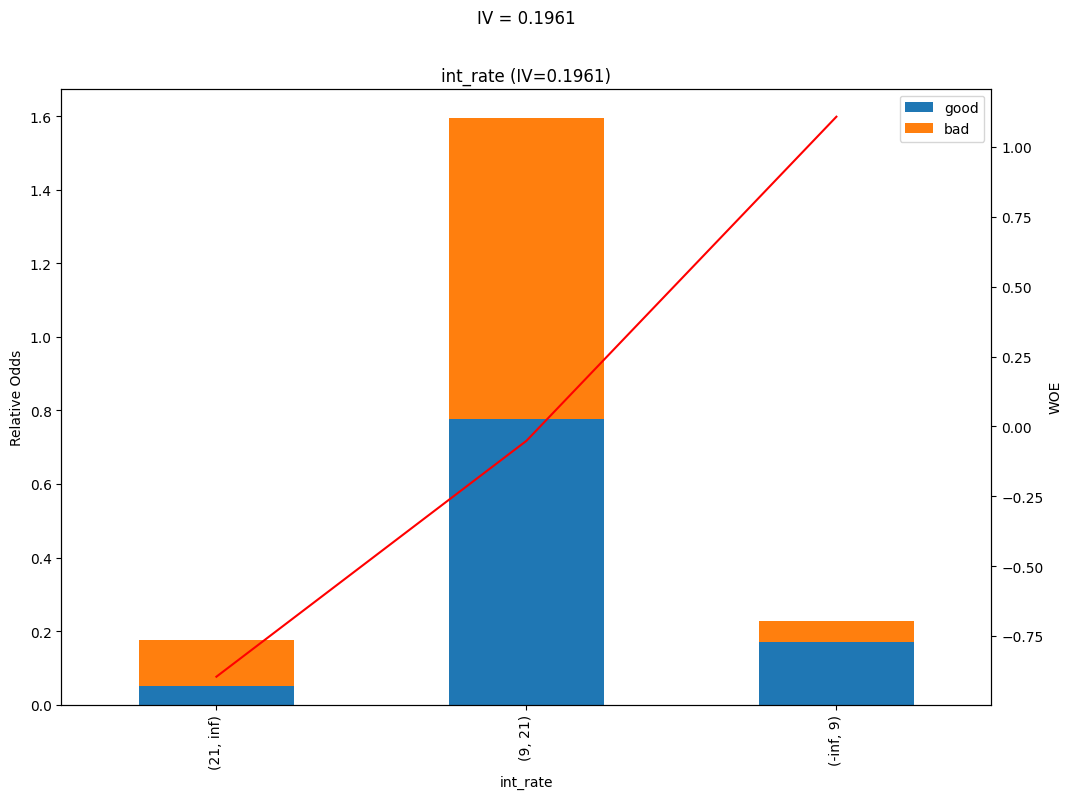

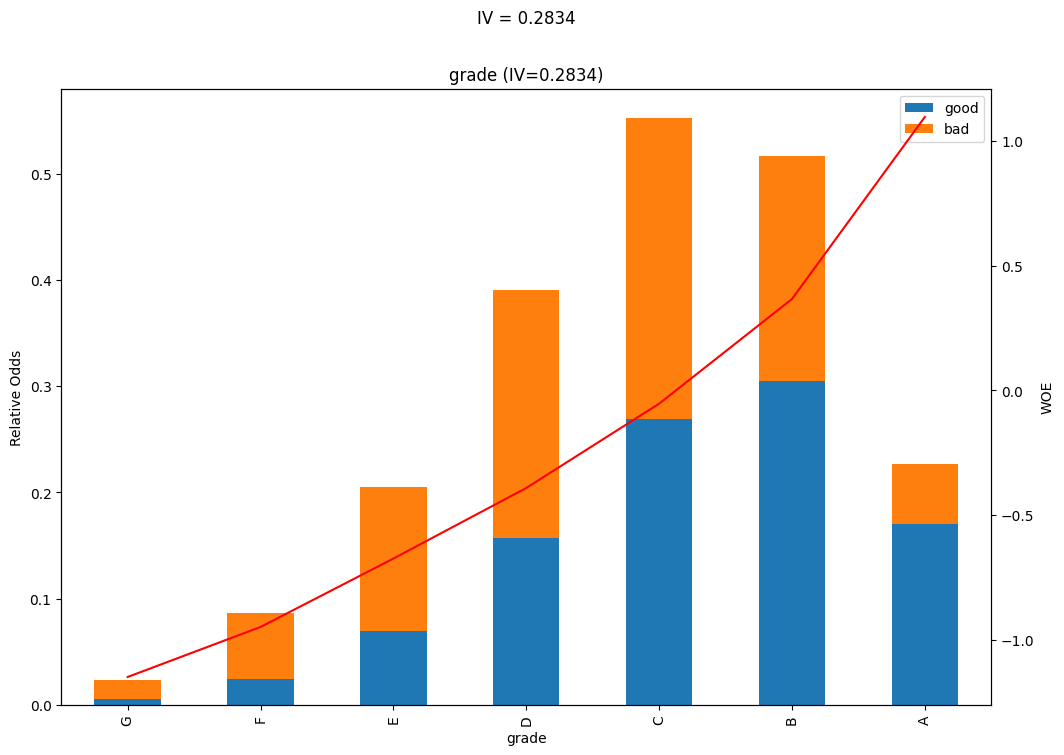

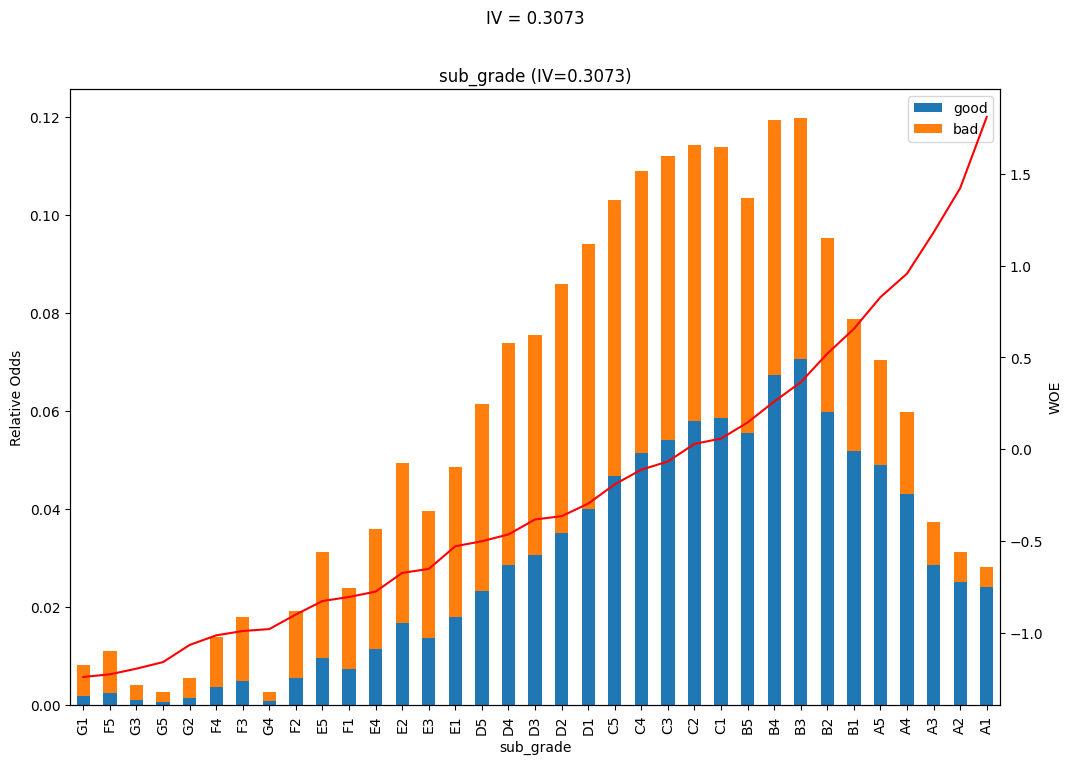

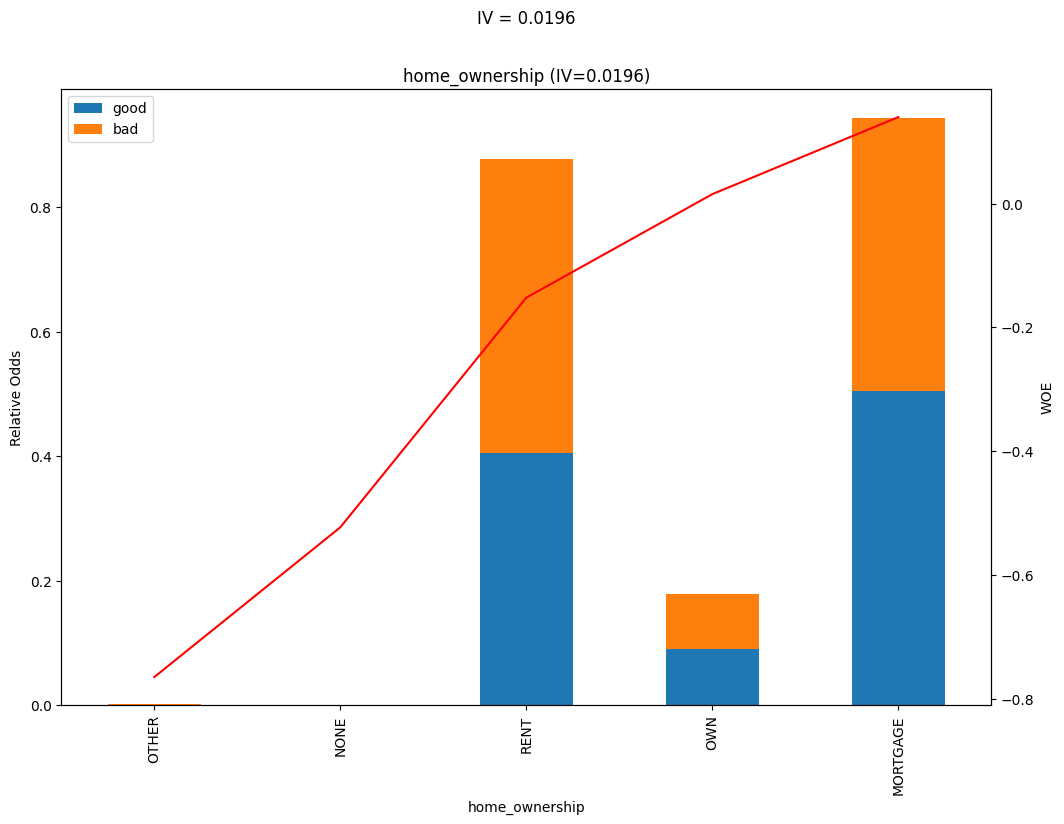

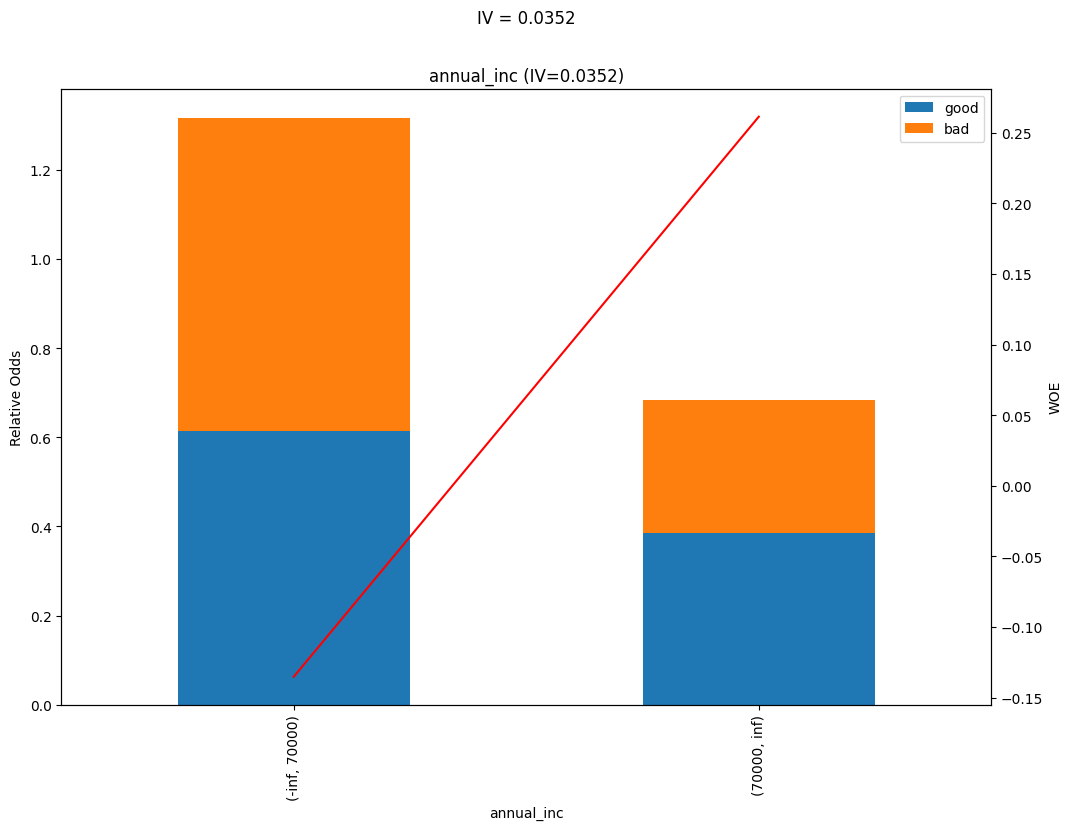

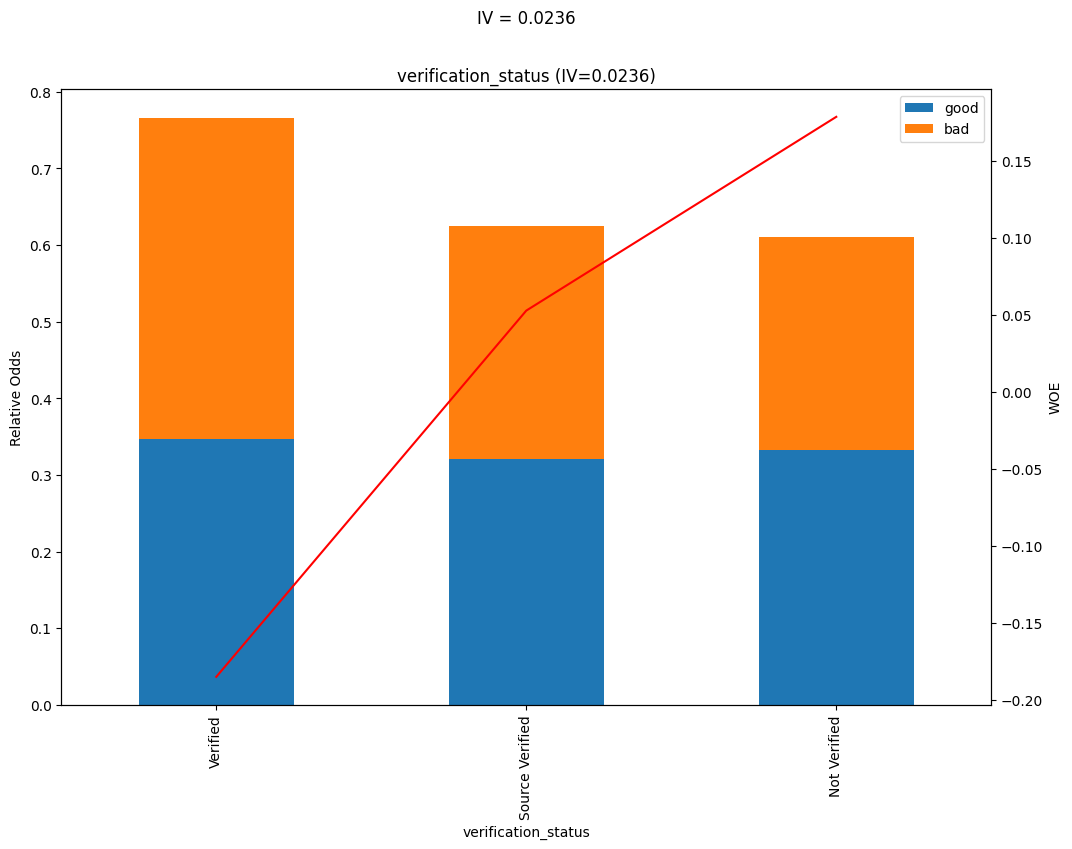

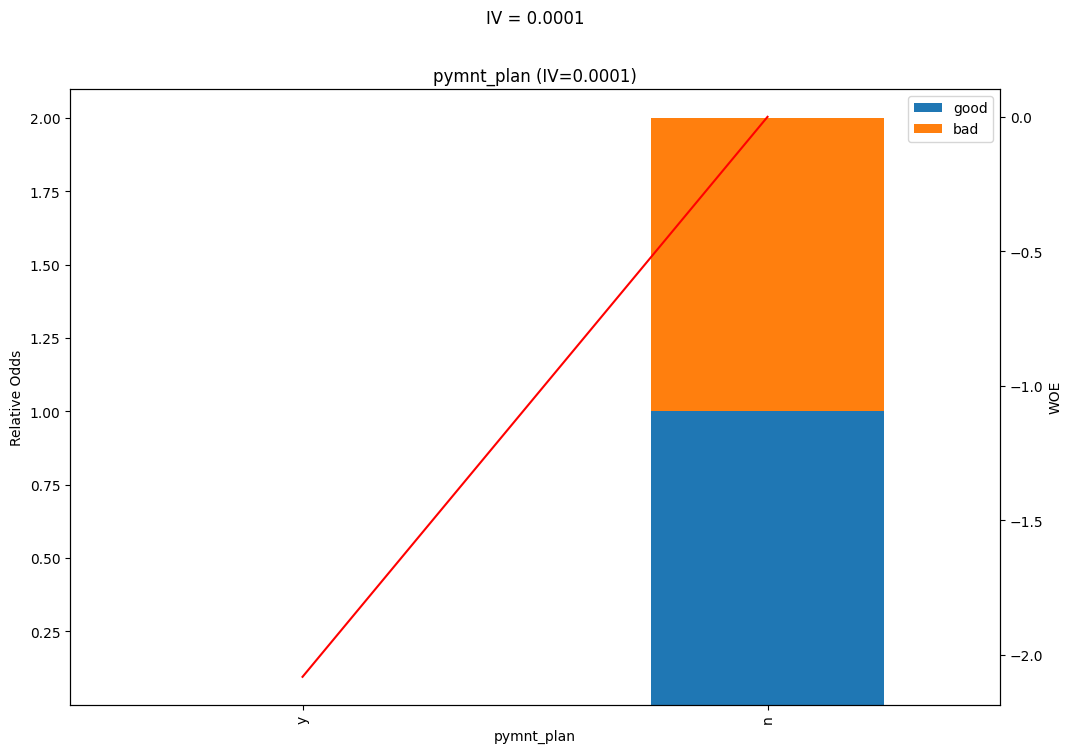

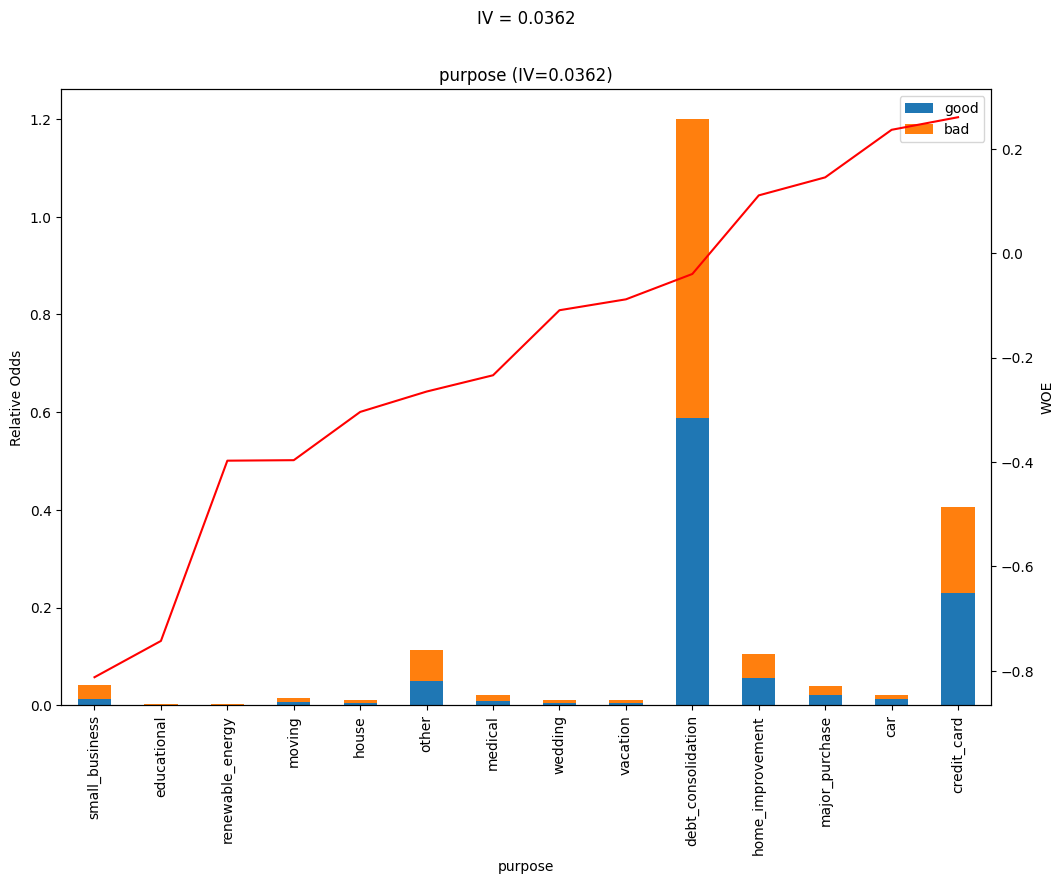

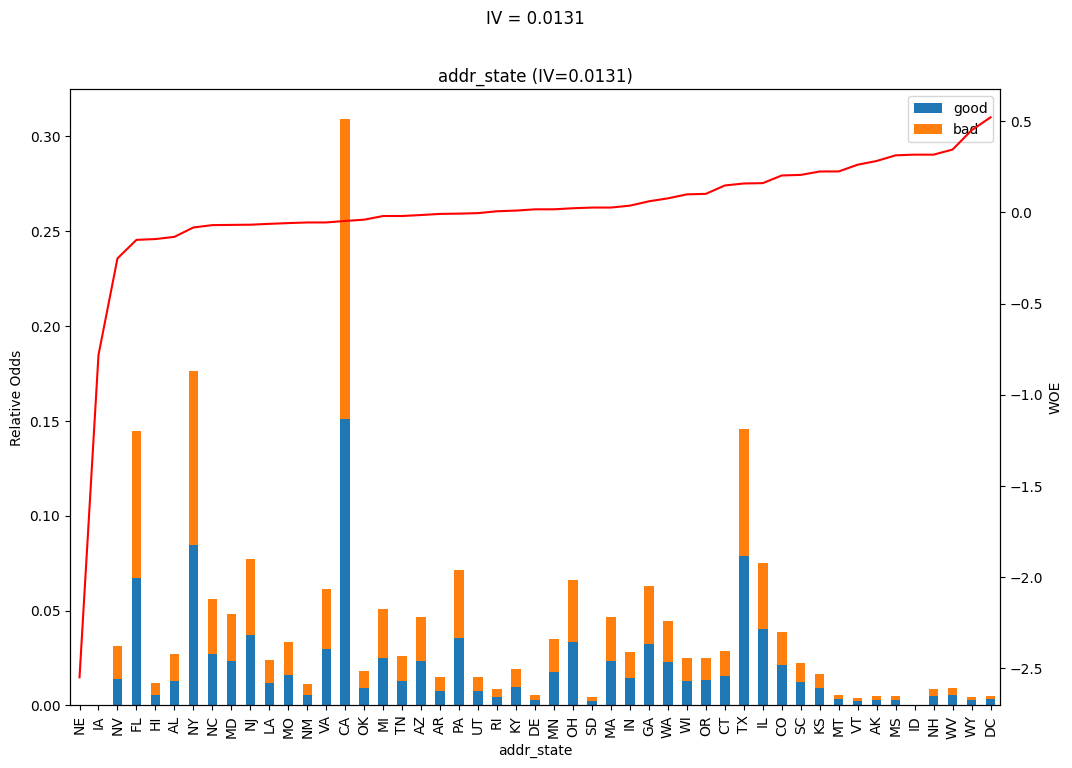

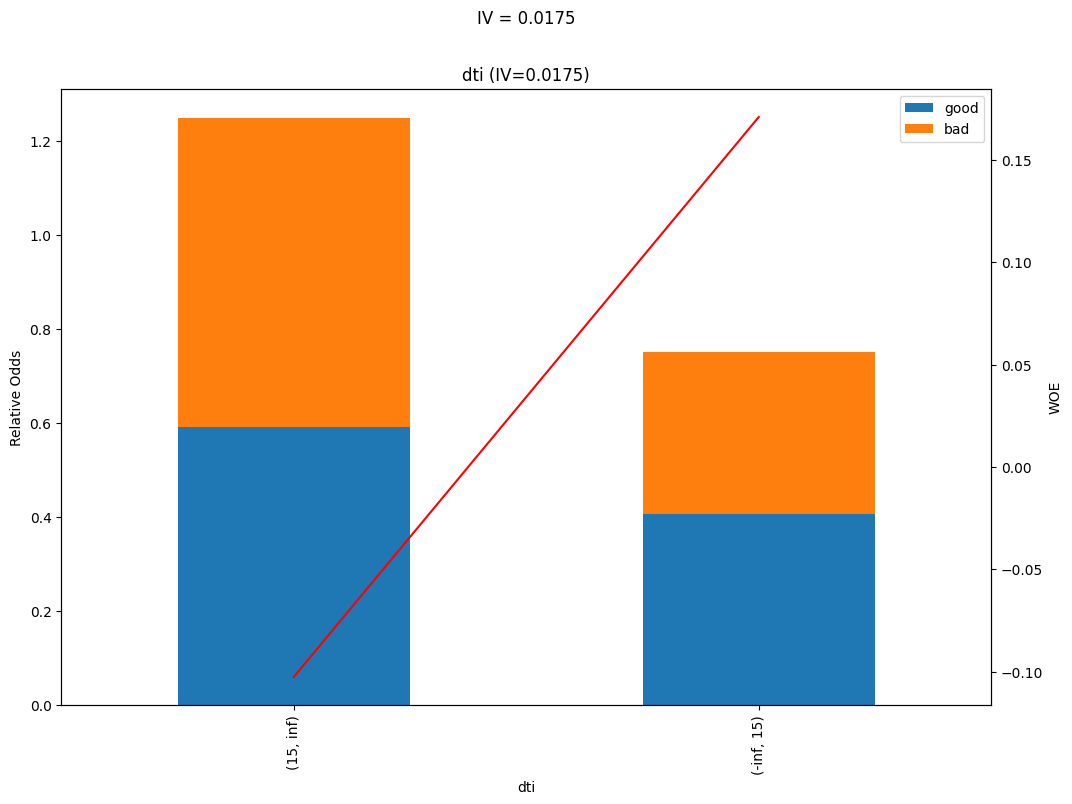

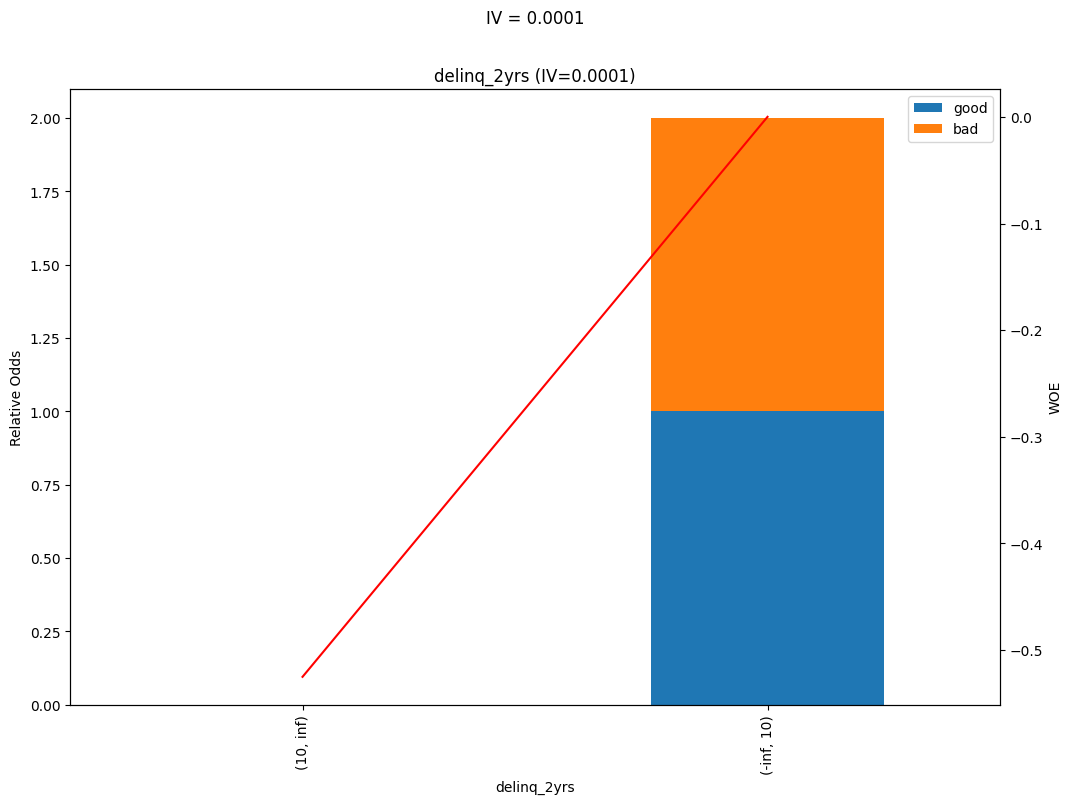

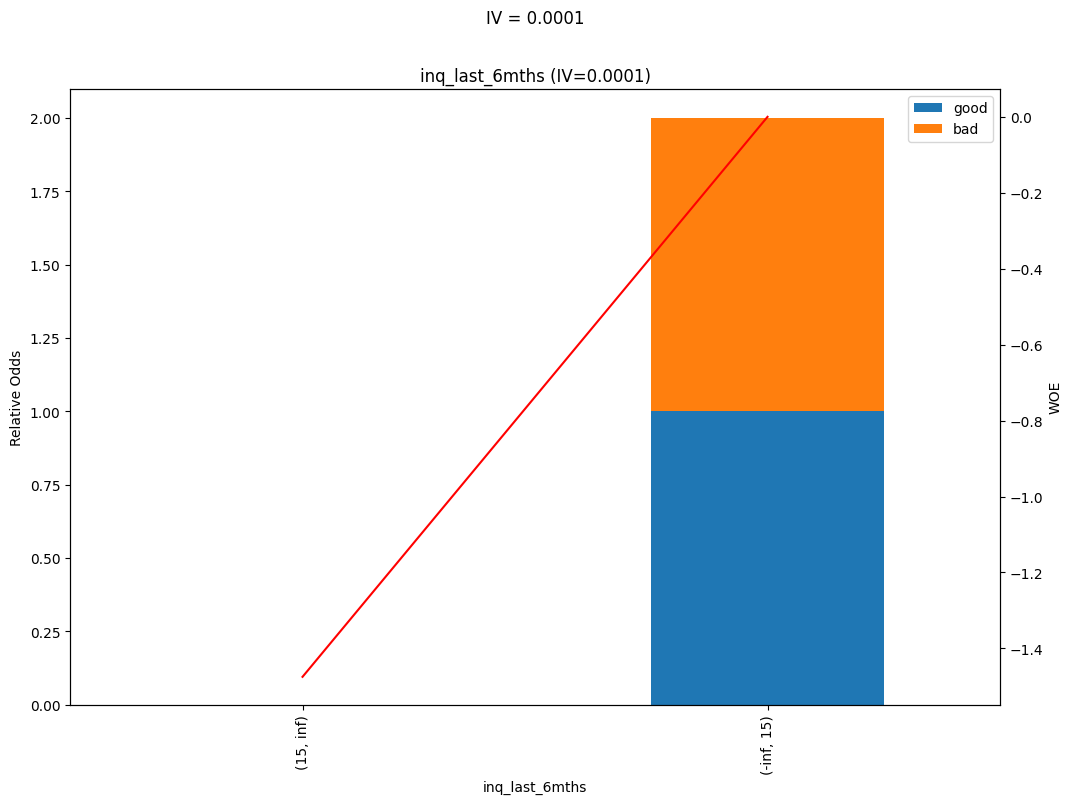

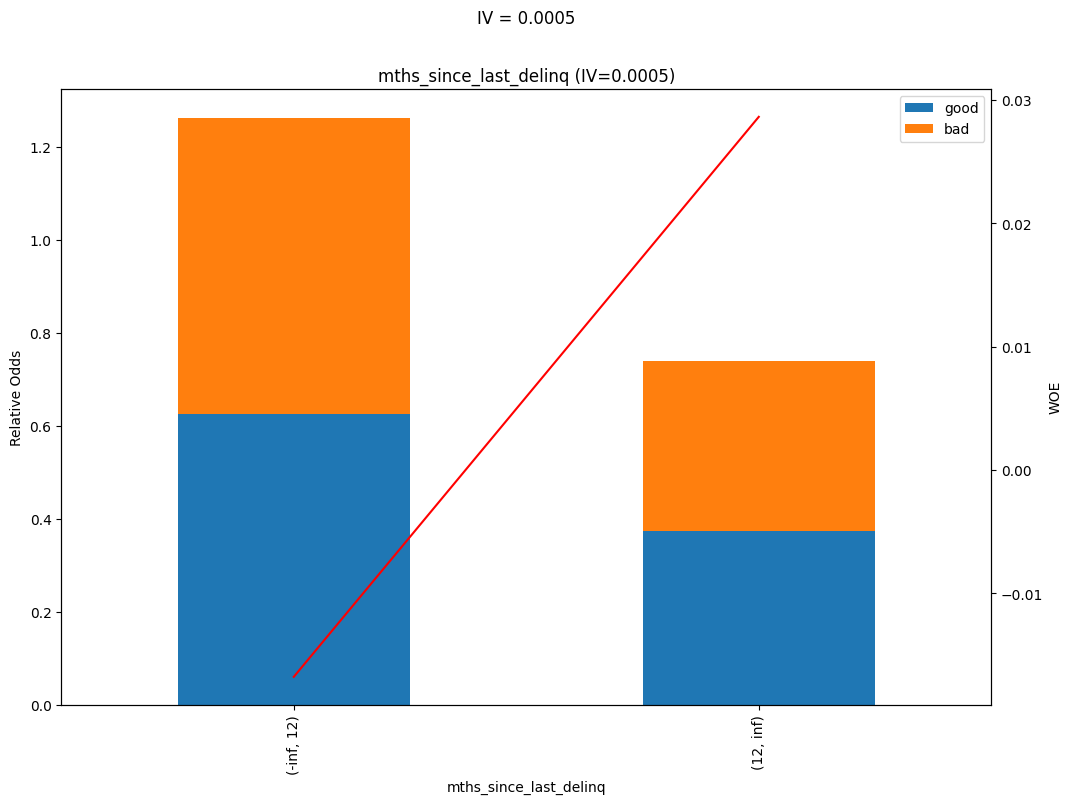

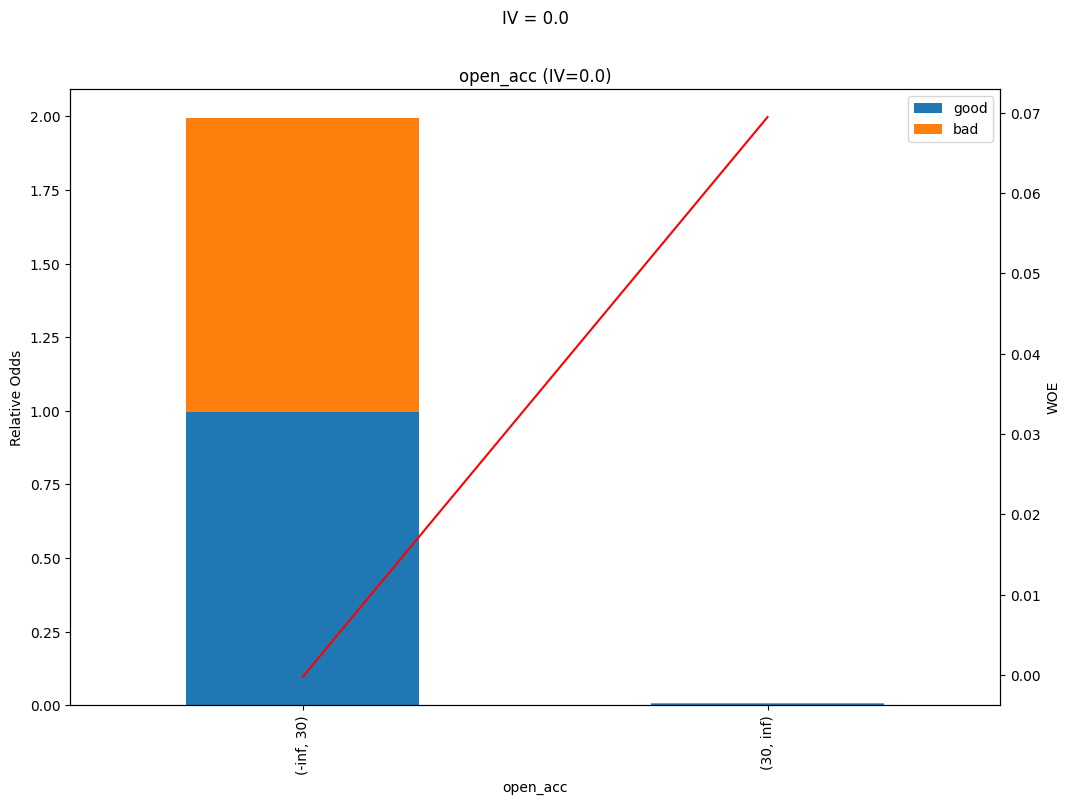

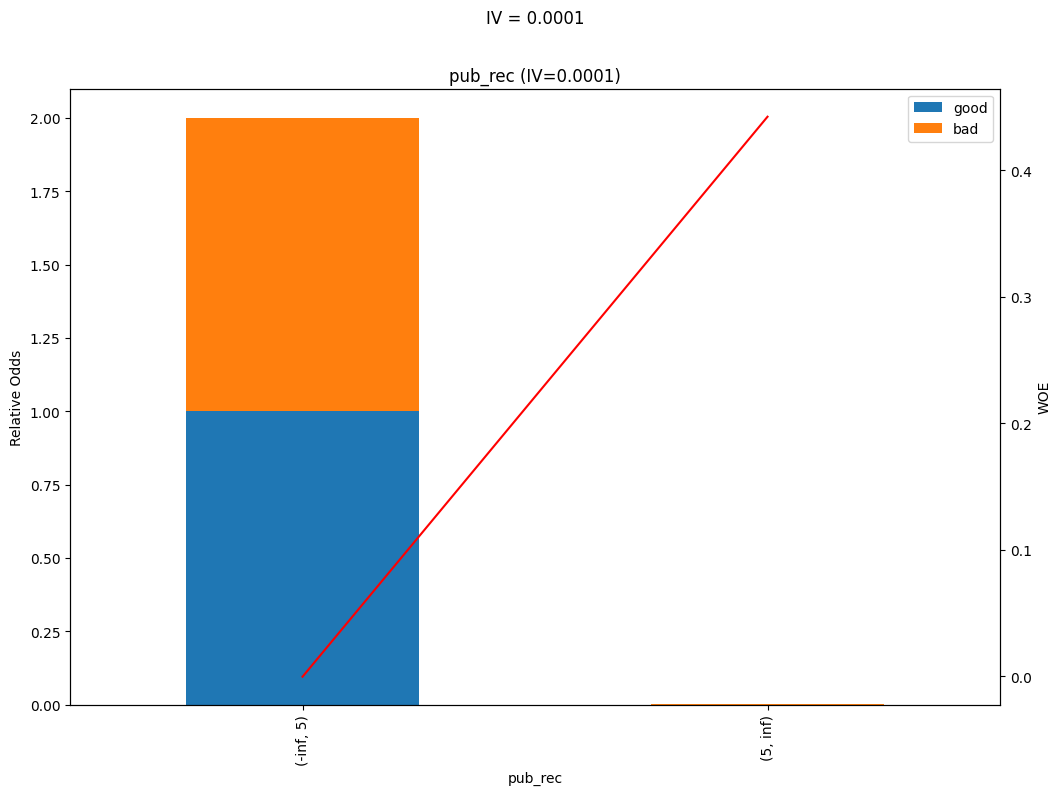

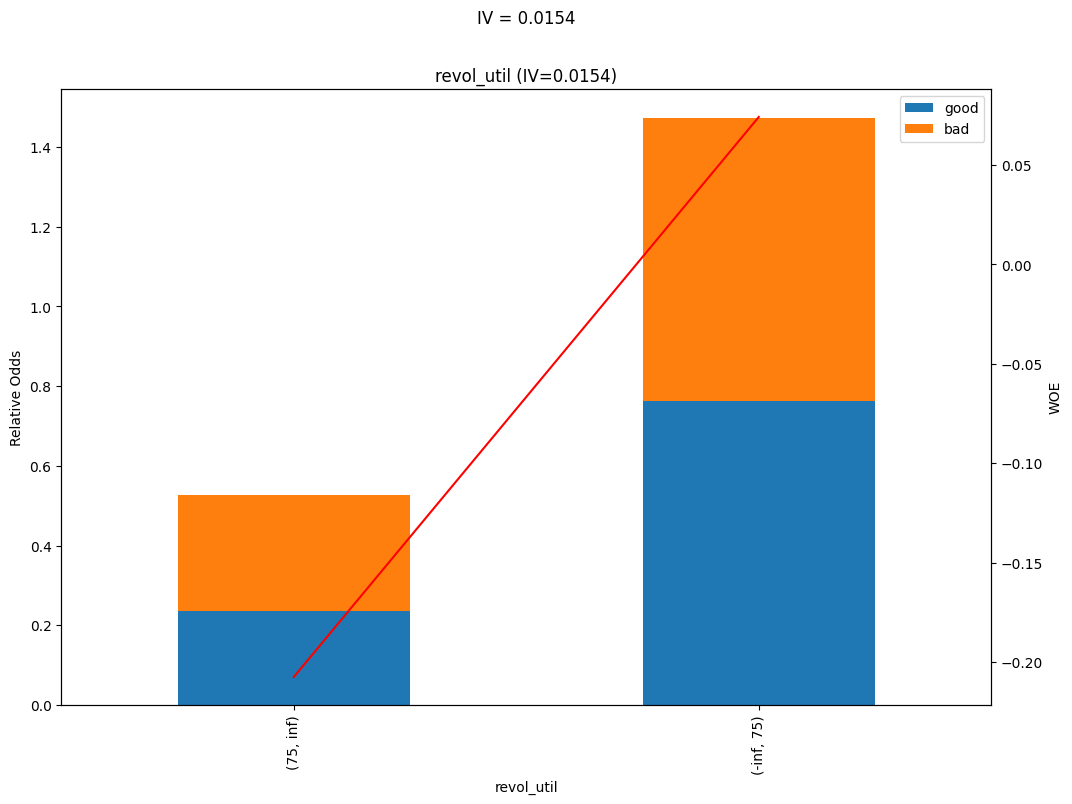

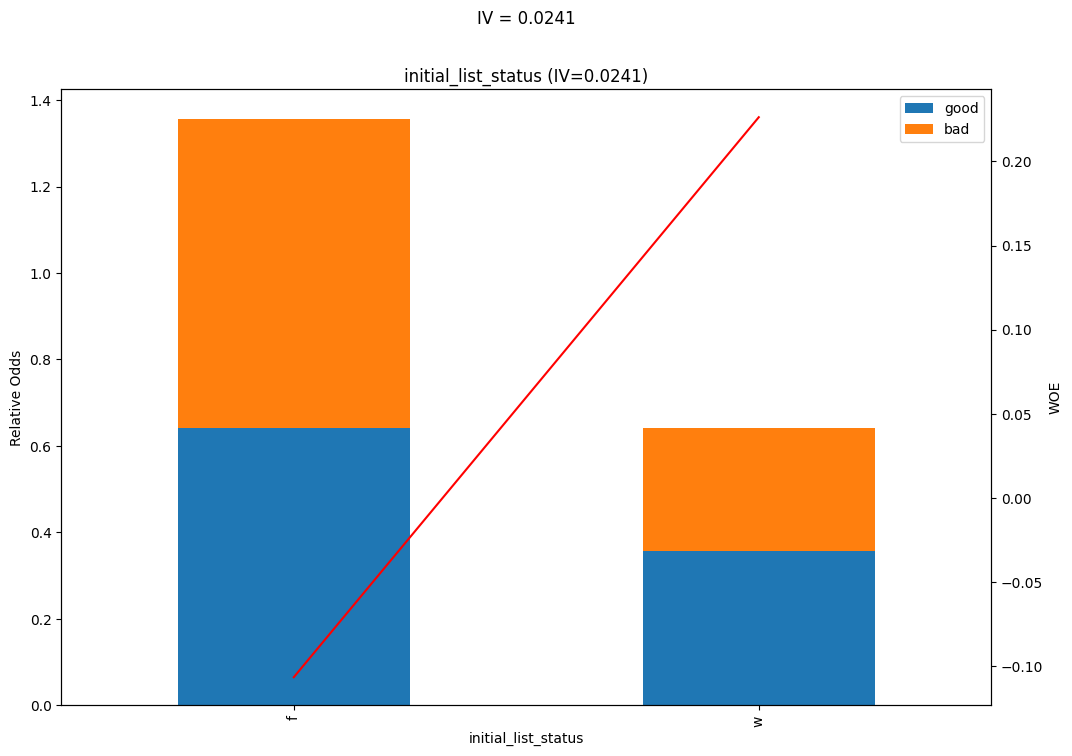

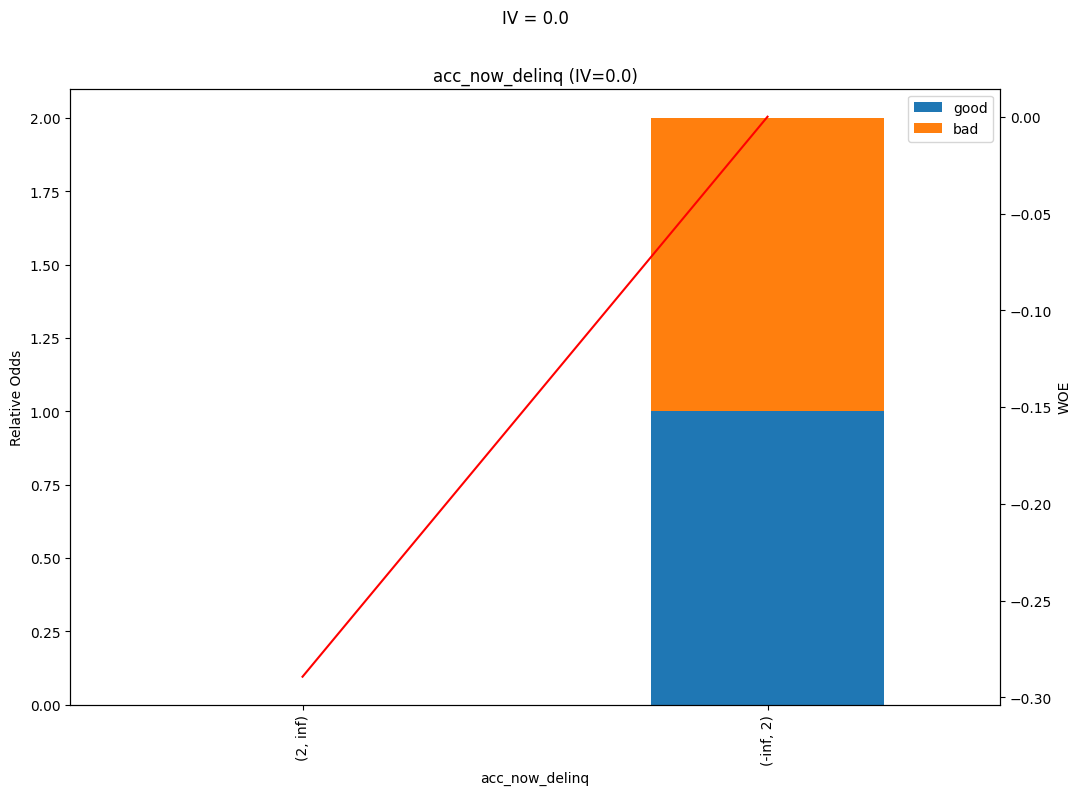

In [53]:
columns_to_plot = ['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util',
       'initial_list_status', 'acc_now_delinq']
plot_woe_bars(woe_t, columns_to_plot)

# MODELS

In [54]:
# Seleccionar características para el conjunto de entrenamiento
seed = 0

cols_to_keep = ['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util', 'initial_list_status', 'acc_now_delinq']

x_train = df.loc[:, cols_to_keep]
y_train = df["status"]

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)

# Transformar la variable de destino en un formato adecuado para la regresión logística
y_train_nd = [1 if val==0 else 0 for val in y_train.values]
y_test_nd = [1 if val==0 else 0 for val in y_test.values]

## Logistic Regression

In [55]:
ml_pipe = Pipeline([
    ('col selector', ColumnSelectorTransformer(columns=cols_to_keep)),
    ('bins', BinningTransformer(bins=bins)),
    ('woe', WOETransformer(columns=cols_to_keep)),
    ('logistic regression', LogisticRegression(random_state=seed))
])

In [56]:
# Seleccionar características para el conjunto de entrenamiento
seed = 0

cols_to_keep = ['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util', 'initial_list_status', 'acc_now_delinq']

x_train = df.loc[:, cols_to_keep]
y_train = df["status"]

x_train1, x_test, y_train1, y_test = train_test_split(x_train, y_train, test_size=0.3)

# Transformar la variable de destino en un formato adecuado para la regresión logística
y_train_nd = [1 if val==0 else 0 for val in y_train.values]
y_train_nd1 = [1 if val==0 else 0 for val in y_train1.values]
y_test_nd = [1 if val==0 else 0 for val in y_test.values]

In [57]:
ml_pipe.fit(x_train, y_train_nd)

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('col selector',
                 ColumnSelectorTransformer(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util', 'initial_list_status', 'acc_now_delinq'])),
                ('bins', BinningT...
                 WOETransformer(columns=['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util', 'initial_list_status', 'acc_now_delinq'], target_mappings={0: 'good', 1: 'bad'})),
                ('logistic regression', LogisticRegression(random_state=0))])

In [58]:
ml_pipe.score(x_train, y_train_nd)

0.8890566680258271

In [59]:
ml_pipe.predict_proba(x_test)

array([[0.11427941, 0.88572059],
       [0.02896984, 0.97103016],
       [0.07037606, 0.92962394],
       ...,
       [0.13715325, 0.86284675],
       [0.11089157, 0.88910843],
       [0.13491922, 0.86508078]])

In [60]:
y_pred = ml_pipe.predict(x_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [61]:
fpr, tpr, threshold = roc_curve(y_test_nd, ml_pipe.predict_proba(x_test)[:, 1])
roc_auc = auc(fpr, tpr)
f1 = f1_score(y_test_nd, y_pred)
print(f"ROC AUC: {roc_auc}")
print(f"F1: {f1}")

ROC AUC: 0.6718711125817846
F1: 0.9411653072601401


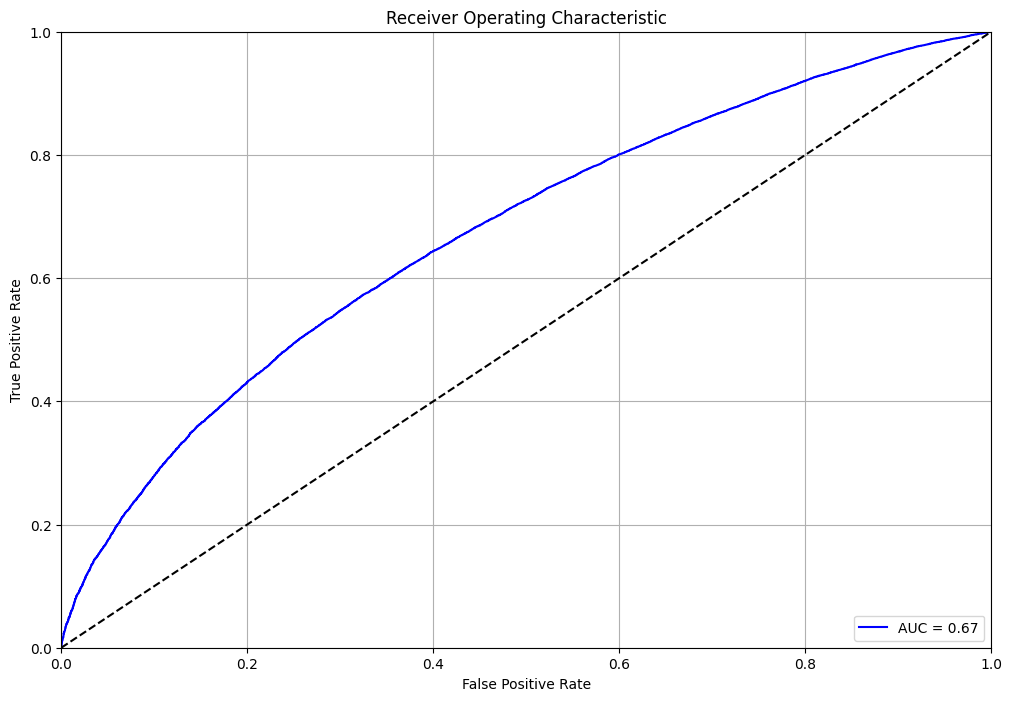

In [62]:
plt.figure(figsize=(12, 8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [63]:
predictions = pd.DataFrame({"y_original": y_train_nd, "y_predicted": ml_pipe.predict_proba(x_train)[:, 1]})
predictions

,y_original,y_predicted
0,1,0.901934
1,0,0.876907
2,1,0.812902
3,1,0.849975
4,1,0.909267
...,...,...
446349,1,0.932331
446350,0,0.830489
446351,1,0.829258
446352,1,0.974559


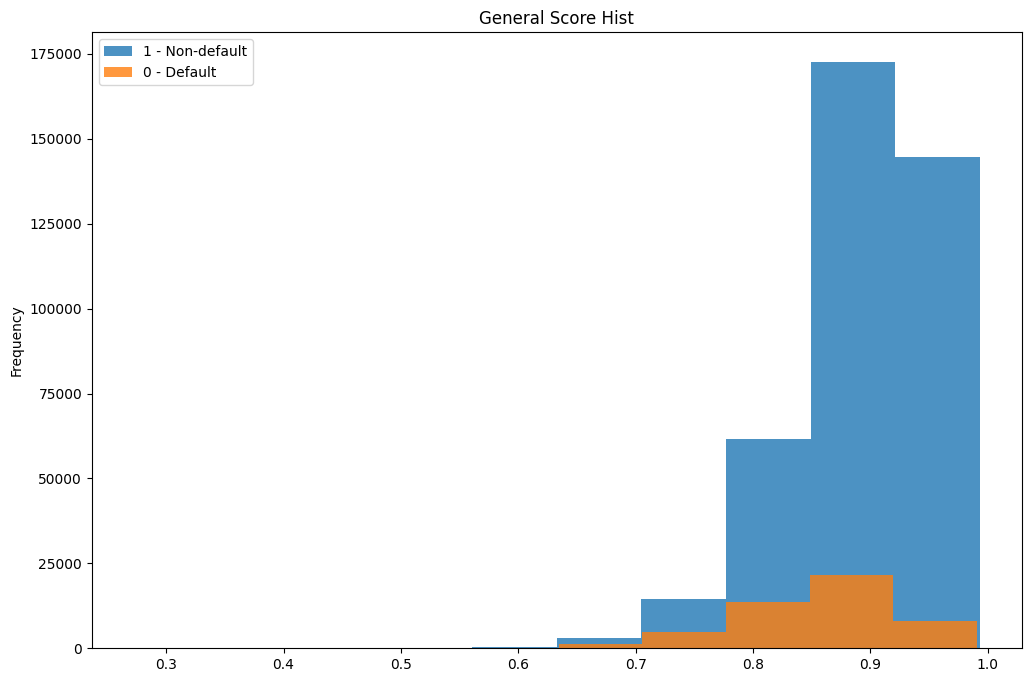

In [64]:
fig, ax = plt.subplots(figsize=(12, 8))

predictions[predictions["y_original"] == 1].plot.hist(title="General Score Hist",
                                                      y="y_predicted",
                                                      bins=10,
                                                      alpha=0.8,
                                                      ax=ax,
                                                      label="1 - Non-default")

predictions[predictions["y_original"] == 0].plot.hist(title="General Score Hist",
                                                      y="y_predicted",
                                                      bins=10,
                                                      alpha=0.8,
                                                      ax=ax,
                                                      label="0 - Default");

In [65]:
# 0: probabilidad de defaul, o sea que el cliente no pague.
predictions[predictions["y_original"] == 0].mean()

y_original     0.000000
y_predicted    0.855351
dtype: float64

In [66]:
# 1: probabilidad de non-defaul, o sea que el cliente si pague.
predictions[predictions["y_original"] == 1].mean()

y_original     1.000000
y_predicted    0.893254
dtype: float64

We predict that the probability that a good customer (who does pay) will pay is 89% and the probability that a bad customer (who does not pay) will pay is 85%.

The model gives a 4% more probability to a good client, that is, it "works".

## Random Forest

In [67]:
rf_pipe = Pipeline([
    ('col selector', ColumnSelectorTransformer(columns=cols_to_keep)),
    ('bins', BinningTransformer(bins=bins)),
    ('woe', WOETransformer(columns=cols_to_keep)),
    ('rf', RandomForestClassifier(random_state=seed))
])

In [68]:
rf_pipe.fit(x_train, y_train_nd)

Pipeline(steps=[('col selector',
                 ColumnSelectorTransformer(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util', 'initial_list_status', 'acc_now_delinq'])),
                ('bins', BinningT...
                 WOETransformer(columns=['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util', 'initial_list_status', 'acc_now_delinq'], target_mappings={0: 'good', 1: 'bad'})),
                ('rf', RandomForestClassifier(random_state=0))])

In [69]:
rf_pipe.score(x_train, y_train_nd)

0.9530619194630271

In [70]:
rf_pipe.predict_proba(x_test)

array([[0.14035606, 0.85964394],
       [0.02      , 0.98      ],
       [0.04      , 0.96      ],
       ...,
       [0.017     , 0.983     ],
       [0.05      , 0.95      ],
       [0.03      , 0.97      ]])

In [71]:
rf_y_pred = rf_pipe.predict(x_test)

In [72]:
rf_fpr, rf_tpr, threshold_rf = roc_curve(y_test_nd, rf_pipe.predict_proba(x_test)[:, 1])
rf_roc_auc = auc(rf_fpr, rf_tpr)
rf_f1 = f1_score(y_test_nd, rf_y_pred)
print(f"ROC AUC: {rf_roc_auc}")
print(f"F1: {rf_f1}")

ROC AUC: 0.9791081795955086
F1: 0.9741824299034669


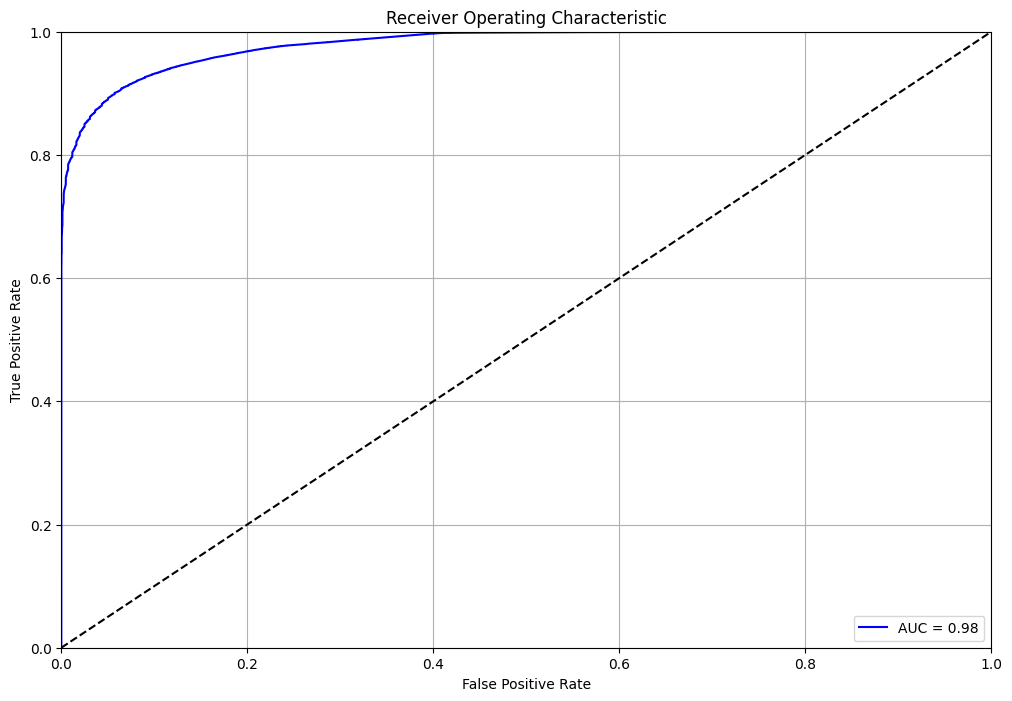

In [73]:
plt.figure(figsize=(12, 8))
plt.title('Receiver Operating Characteristic')
plt.plot(rf_fpr, rf_tpr, 'b', label = 'AUC = %0.2f' % rf_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [74]:
predictions_rf = pd.DataFrame({"y_original": y_train_nd, "y_predicted": rf_pipe.predict_proba(x_train)[:, 1]})

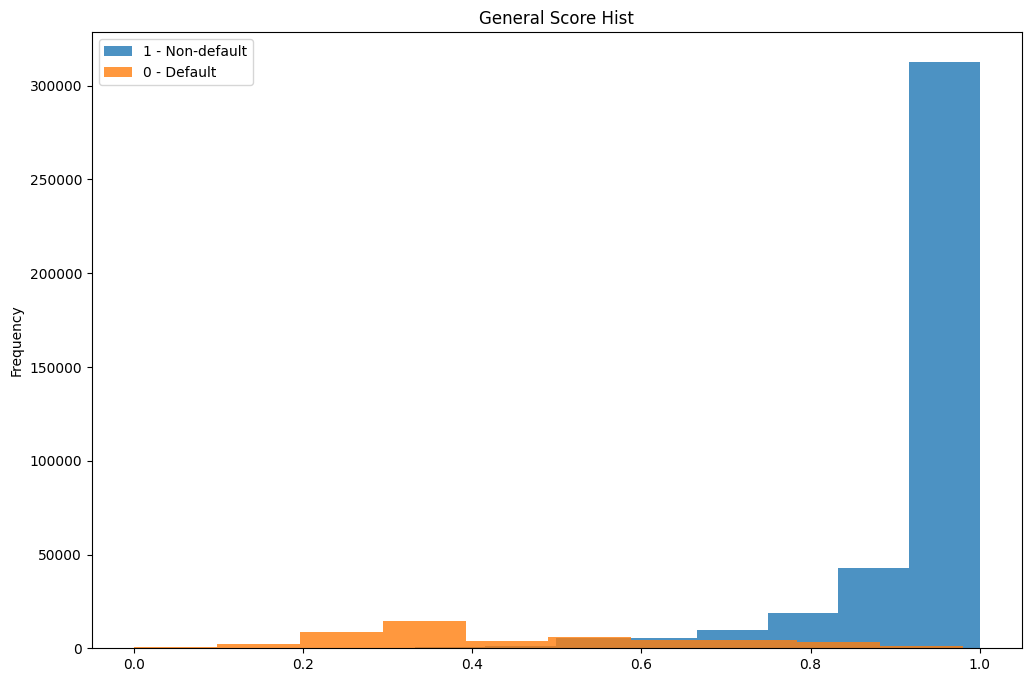

In [75]:
fig, ax = plt.subplots(figsize=(12, 8))

predictions_rf[predictions_rf["y_original"] == 1].plot.hist(title="General Score Hist",
                                                      y="y_predicted",
                                                      bins=10,
                                                      alpha=0.8,
                                                      ax=ax,
                                                      label="1 - Non-default")

predictions_rf[predictions_rf["y_original"] == 0].plot.hist(title="General Score Hist",
                                                      y="y_predicted",
                                                      bins=10,
                                                      alpha=0.8,
                                                      ax=ax,
                                                      label="0 - Default");

In [76]:
# 0: probabilidad de defaul, o sea que el cliente no pague.
predictions_rf[predictions_rf["y_original"] == 0].mean()

y_original     0.000000
y_predicted    0.451926
dtype: float64

In [77]:
# 1: probabilidad de non-defaul, o sea que el cliente si pague.
predictions_rf[predictions_rf["y_original"] == 1].mean()

y_original     1.000000
y_predicted    0.942649
dtype: float64

As you can see with our different scores, this is not a perfect model but it works really well.

## XgBoost

In [78]:
xgb_pipe = Pipeline([
    ('col selector', ColumnSelectorTransformer(columns=cols_to_keep)),
    ('bins', BinningTransformer(bins=bins)),
    ('woe', WOETransformer(columns=cols_to_keep)),
    ('xgb', XGBClassifier(n_estimators=100,  random_state=seed))
])

In [79]:
xgb_pipe.fit(x_train, y_train_nd)

Pipeline(steps=[('col selector',
                 ColumnSelectorTransformer(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util', 'initial_list_status', 'acc_now_delinq'])),
                ('bins', BinningT...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=0, ...))])

In [80]:
xgb_pipe.score(x_train, y_train_nd)

0.8896167615838549

In [81]:
xgb_pipe.predict_proba(x_test)

array([[0.09524888, 0.9047511 ],
       [0.02555865, 0.97444135],
       [0.09845817, 0.9015418 ],
       ...,
       [0.1215297 , 0.8784703 ],
       [0.11124891, 0.8887511 ],
       [0.11868763, 0.8813124 ]], dtype=float32)

In [82]:
xgb_y_pred = xgb_pipe.predict(x_test)

In [83]:
xgb_fpr, xgb_tpr, xgb_threshold = roc_curve(y_test_nd, xgb_pipe.predict_proba(x_test)[:, 1])
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)
xgb_f1 = f1_score(y_test_nd, xgb_y_pred)
print(f"ROC AUC: {xgb_roc_auc}")
print(f"F1: {xgb_f1}")

ROC AUC: 0.6988746977518883
F1: 0.941447748324988


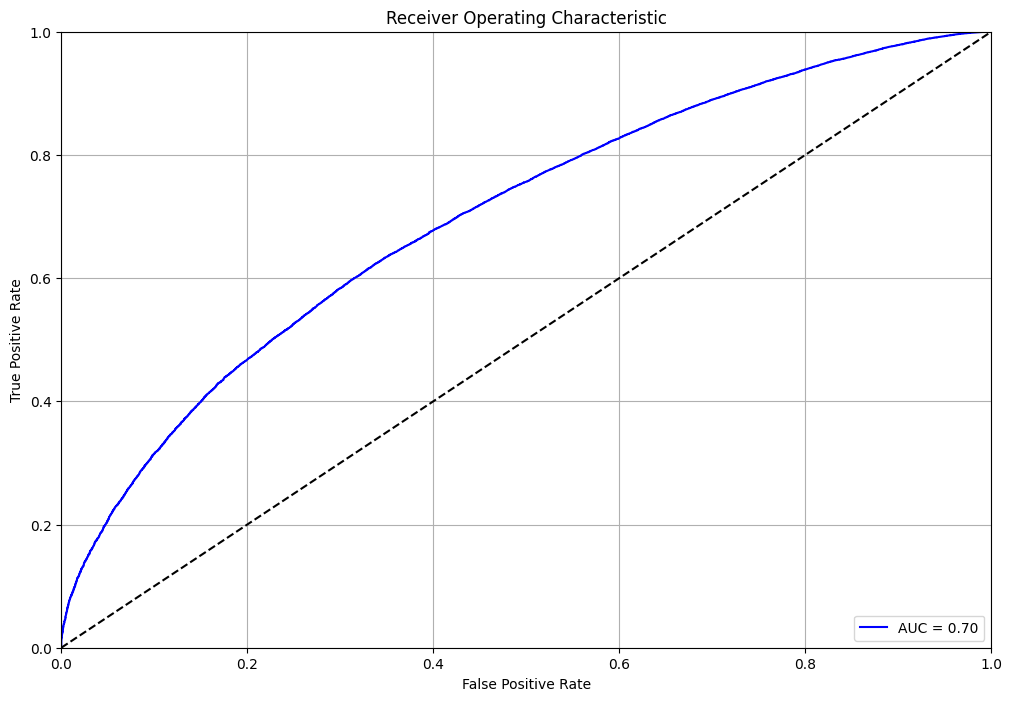

In [84]:
plt.figure(figsize=(12, 8))
plt.title('Receiver Operating Characteristic')
plt.plot(xgb_fpr, xgb_tpr, 'b', label = 'AUC = %0.2f' % xgb_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [85]:
predictions_xgb = pd.DataFrame({"y_original": y_train_nd, "y_predicted": xgb_pipe.predict_proba(x_train)[:, 1]})

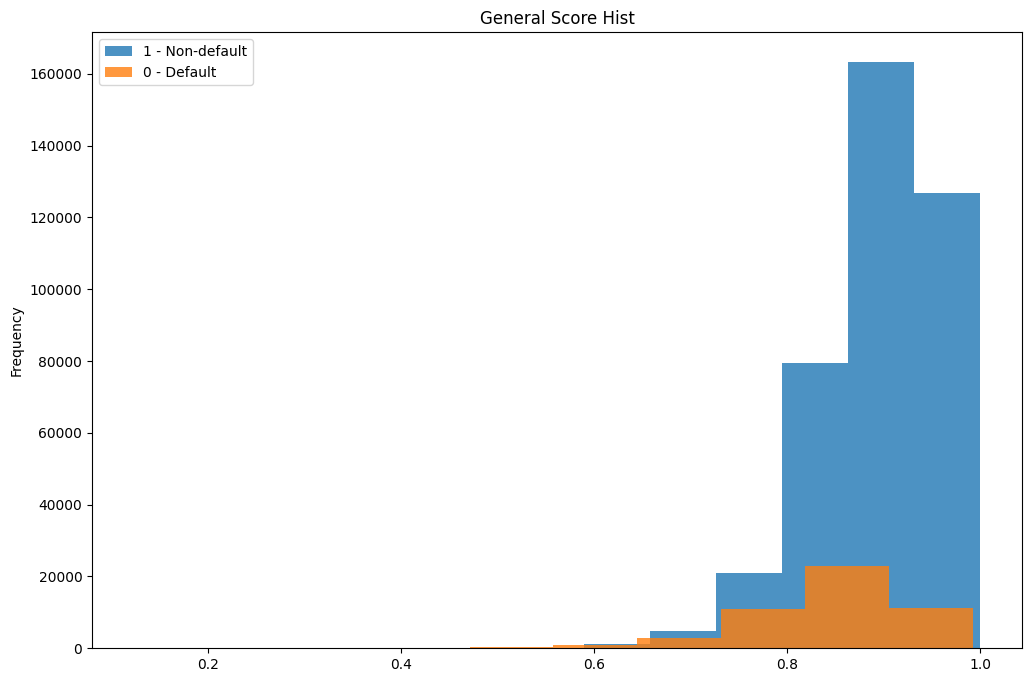

In [86]:
fig, ax = plt.subplots(figsize=(12, 8))

predictions_xgb[predictions_xgb["y_original"] == 1].plot.hist(title="General Score Hist",
                                                      y="y_predicted",
                                                      bins=10,
                                                      alpha=0.8,
                                                      ax=ax,
                                                      label="1 - Non-default")

predictions_xgb[predictions_xgb["y_original"] == 0].plot.hist(title="General Score Hist",
                                                      y="y_predicted",
                                                      bins=10,
                                                      alpha=0.8,
                                                      ax=ax,
                                                      label="0 - Default");

In [87]:
# 0: probabilidad de defaul, o sea que el cliente no pague.
predictions_xgb[predictions_xgb["y_original"] == 0].mean()

y_original     0.000000
y_predicted    0.842989
dtype: float64

In [88]:
# 1: probabilidad de non-defaul, o sea que el cliente si pague.
predictions_xgb[predictions_xgb["y_original"] == 1].mean()

y_original     1.000000
y_predicted    0.894772
dtype: float64

Comparing this model with the last one we can see that it works and taking in count "ROC", it is a good model.

## Lasso

In [110]:
from sklearn.preprocessing import StandardScaler

In [111]:
lasso_pipe = Pipeline([
    ('col selector', ColumnSelectorTransformer(columns=cols_to_keep)),
    ('bins', BinningTransformer(bins=bins)),
    ('woe', WOETransformer(columns=cols_to_keep)),
    # ('logistic regression', LogisticRegression(random_state=seed))
    # ('rf', RandomForestClassifier(random_state=seed))
    ('scaler', StandardScaler()),  # Preprocesamiento de datos
    ('lasso', LogisticRegression(penalty='l1', solver='liblinear'))
])

In [112]:
# Fit the Lasso model on the training data
lasso_pipe.fit(x_train, y_train)

Pipeline(steps=[('col selector',
                 ColumnSelectorTransformer(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util', 'initial_list_status', 'acc_now_delinq'])),
                ('bins', BinningT...
                 WOETransformer(columns=['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util', 'initial_list_status', 'acc_now_delinq'], target_mappings={0: 'good', 1: 'bad'})),
                ('scaler', StandardScaler()),
                ('lasso',
                 LogisticRegression(penalty='l1', solver='liblinear'))])

In [113]:
lasso_pipe.score(x_train, y_train_nd)

0.11094333197417297

In [114]:
lasso_pipe.predict_proba(x_test)

array([[0.88557928, 0.11442072],
       [0.97112028, 0.02887972],
       [0.92983269, 0.07016731],
       ...,
       [0.86308786, 0.13691214],
       [0.88947723, 0.11052277],
       [0.8647812 , 0.1352188 ]])

In [115]:
# Predecir los valores de la variable objetivo en el conjunto de prueba
y_pred_lasso = lasso_pipe.predict(x_test)

In [116]:
lasso_fpr, lasso_tpr, lasso_threshold = roc_curve(y_test_nd, lasso_pipe.predict_proba(x_test)[:, 1])
lasso_roc_auc = auc(lasso_fpr, lasso_tpr)
lasso_f1 = f1_score(y_test_nd, y_pred_lasso)
print(f"ROC AUC: {lasso_roc_auc}")
print(f"F1: {lasso_f1}")

ROC AUC: 0.32813651963756996
F1: 8.400819920024194e-05


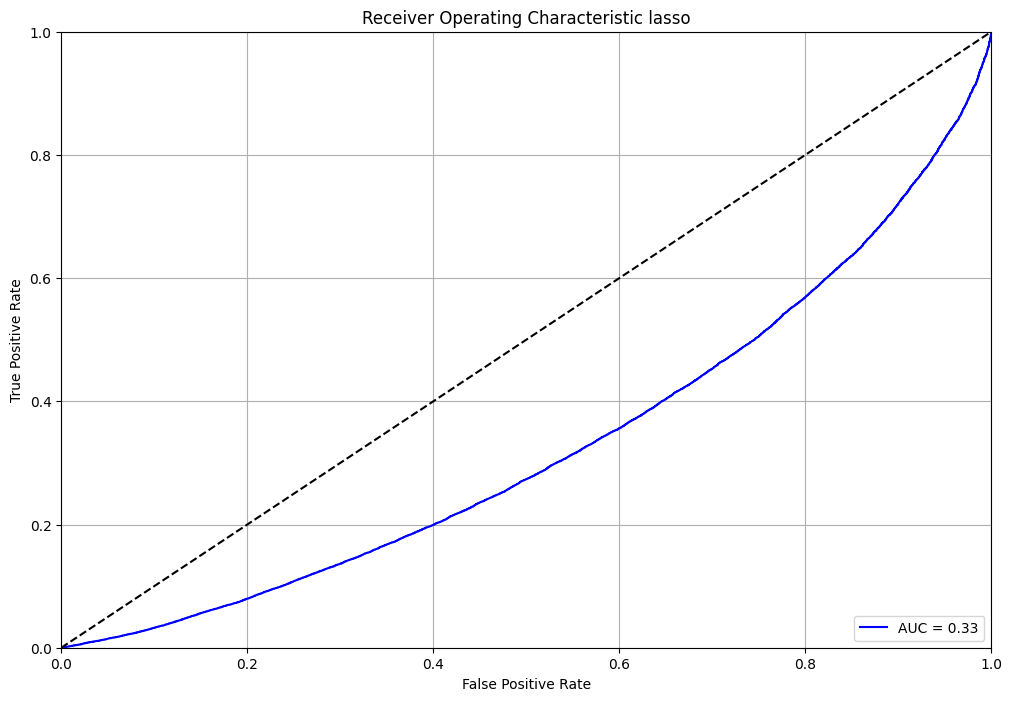

In [117]:
plt.figure(figsize=(12, 8))
plt.title('Receiver Operating Characteristic lasso')
plt.plot(lasso_fpr, lasso_tpr, 'b', label = 'AUC = %0.2f' % lasso_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [118]:
predictions_lasso = pd.DataFrame({"y_original": y_train_nd, "y_predicted": lasso_pipe.predict_proba(x_train)[:, 1]})

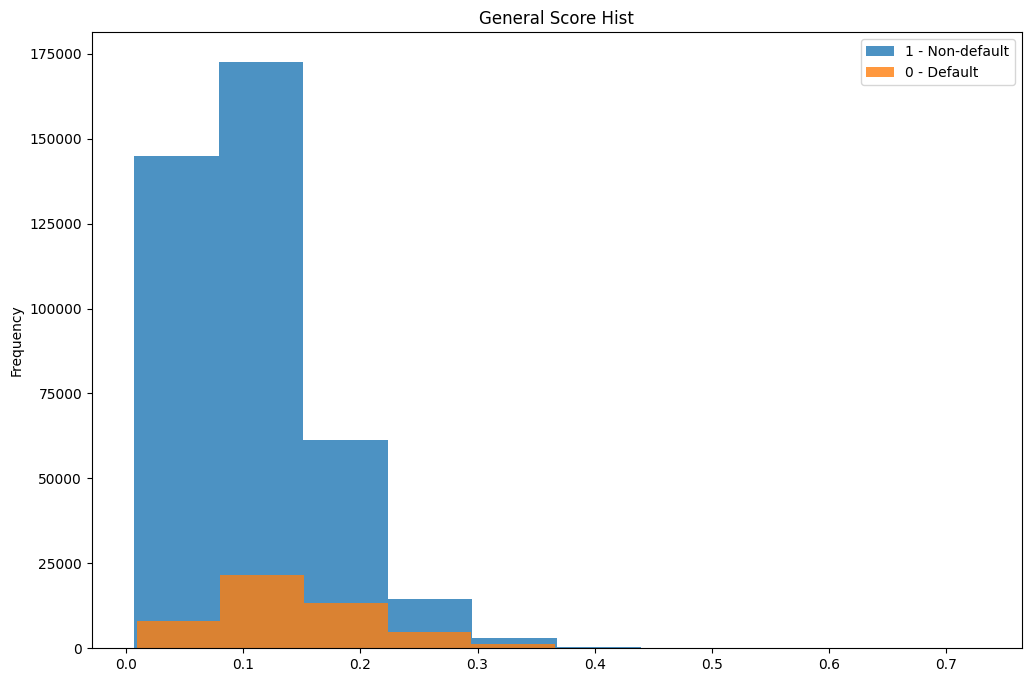

In [119]:
fig, ax = plt.subplots(figsize=(12, 8))

predictions_lasso[predictions_lasso["y_original"] == 1].plot.hist(title="General Score Hist",
                                                      y="y_predicted",
                                                      bins=10,
                                                      alpha=0.8,
                                                      ax=ax,
                                                      label="1 - Non-default")

predictions_lasso[predictions_lasso["y_original"] == 0].plot.hist(title="General Score Hist",
                                                      y="y_predicted",
                                                      bins=10,
                                                      alpha=0.8,
                                                      ax=ax,
                                                      label="0 - Default");

In [120]:
# 0: probabilidad de defaul, o sea que el cliente no pague.
predictions_lasso[predictions_lasso["y_original"] == 0].mean()

y_original     0.000000
y_predicted    0.144681
dtype: float64

In [121]:
# 1: probabilidad de non-defaul, o sea que el cliente si pague.
predictions_lasso[predictions_lasso["y_original"] == 1].mean()

y_original     1.000000
y_predicted    0.106746
dtype: float64

This model makes it more likely that you will pay a bad customer, that is, it doesn't work.

## Stacking (pending actions)

In [91]:
estimators = [
    ("Linear Regression", ml_pipe),
    ("Random Forest", rf_pipe),
    ("Xgboost", xgb_pipe)
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_regressor

meta_model = LogisticRegression()

In [96]:
stack_model = StackingClassifier(
    classifiers = [ml_pipe, rf_pipe, xgb_pipe],
    meta_classifier = meta_model,
    use_probas = True,
    average_probas = True)

In [97]:
stack_model.fit(x_train, y_train_nd)

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(average_probas=True,
                   classifiers=[Pipeline(steps=[('col selector',
                                                 ColumnSelectorTransformer(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util', 'initi...
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=0, ...))])],
                   meta_classifier=LogisticRegression(), use_probas=True)

In [98]:
stack_model.score(x_train, y_train_nd)

0.9443558251970409

In [99]:
stack_model.predict_proba(x_test)

array([[0.02985442, 0.97014558],
       [0.00274765, 0.99725235],
       [0.00886062, 0.99113938],
       ...,
       [0.01580661, 0.98419339],
       [0.01533083, 0.98466917],
       [0.01692404, 0.98307596]])

In [101]:
y_pred_sm = stack_model.predict(x_test)

In [102]:
sm_fpr, sm_tpr, sm_threshold = roc_curve(y_test_nd, stack_model.predict_proba(x_test)[:, 1])
sm_roc_auc = auc(sm_fpr, sm_tpr)
sm_f1 = f1_score(y_test_nd, y_pred_sm)
print(f"ROC AUC: {sm_roc_auc}")
print(f"F1: {sm_f1}")

ROC AUC: 0.9543711385486098
F1: 0.9690368447030814


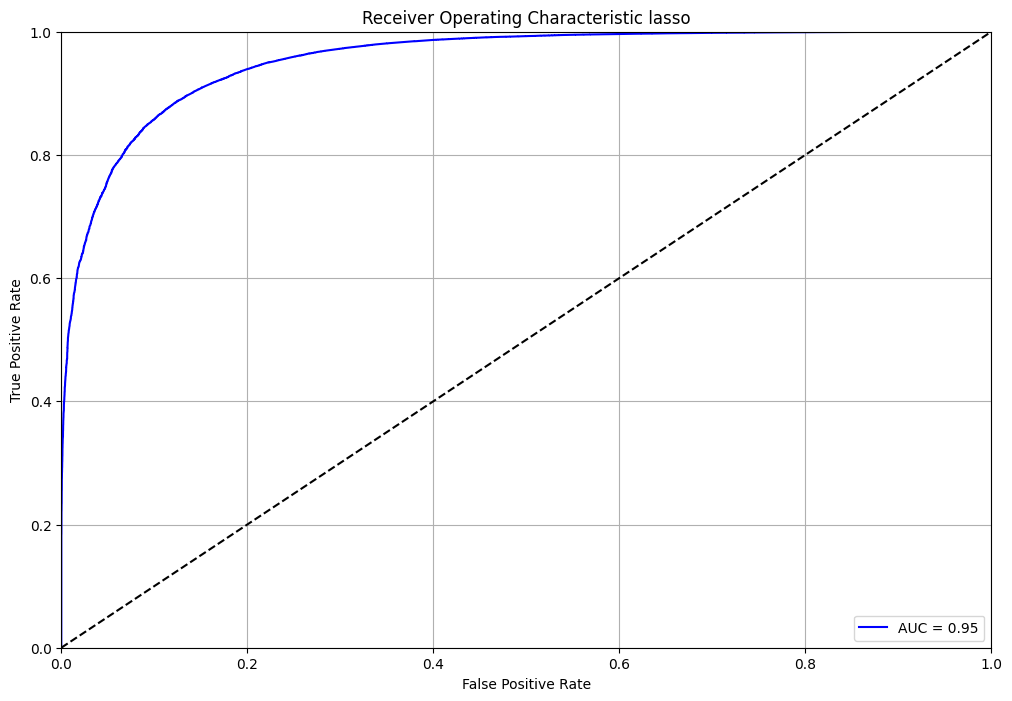

In [103]:
plt.figure(figsize=(12, 8))
plt.title('Receiver Operating Characteristic lasso')
plt.plot(sm_fpr, sm_tpr, 'b', label = 'AUC = %0.2f' % sm_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [104]:
predictions_sm = pd.DataFrame({"y_original": y_train_nd, 
                               "y_predicted": stack_model.predict_proba(x_train)[:, 1]})

In [106]:
predictions_sm[predictions_sm["y_original"] == 1].plot.hist(title="General Score Hist",
                                                      y="y_predicted",
                                                      bins=10,
                                                      alpha=0.8,
                                                      ax=ax,
                                                      label="1 - Non-default")

<Axes: title={'center': 'General Score Hist'}, ylabel='Frequency'>

In [107]:
predictions_sm[predictions_sm["y_original"] == 0].plot.hist(title="General Score Hist",
                                                      y="y_predicted",
                                                      bins=10,
                                                      alpha=0.8,
                                                      ax=ax,
                                                      label="0 - Default");

In [108]:
# 0: probabilidad de defaul, o sea que el cliente no pague.
predictions_sm[predictions_sm["y_original"] == 0].mean()

y_original     0.000000
y_predicted    0.384906
dtype: float64

In [109]:
# 1: probabilidad de non-defaul, o sea que el cliente si pague.
predictions_sm[predictions_sm["y_original"] == 1].mean()

y_original     1.000000
y_predicted    0.951964
dtype: float64

##### 